**PACKAGES**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")

**PART 1:** Loading, converting and cleaning of the data.

Convert the dataset into a pandas dataframe. The column utc_timestamp will be the index of the dataframe I'm going to use.

In [3]:
wind_energy = pd.read_csv('WindEnergy.csv', sep=',', parse_dates=['utc_timestamp'], index_col='utc_timestamp')
wind_energy = wind_energy.asfreq('d') 
wind_energy

,wind_generation_actual,wind_capacity,temperature
utc_timestamp,,,
2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908
...,...,...,...
2019-12-26 00:00:00+00:00,132739.0,50424.125,2.790
2019-12-27 00:00:00+00:00,146590.0,50427.000,1.327
2019-12-28 00:00:00+00:00,159126.0,50427.292,-1.441


Looking more into the dataset we see that it has three different features.
- wind_generation_actual: power generated by the turbines in Germany on that day;
- temperature: mean temperature on that day;
-  wind_Capacity: total amunt of power generate through a time interval

Now, we want to clear the dataset

In [4]:
wind_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2017-01-01 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wind_generation_actual  1094 non-null   float64
 1   wind_capacity           1094 non-null   float64
 2   temperature             1094 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB


In [5]:
wind_energy.isnull().sum()

wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64

The dataset is clean and without null values, there is no need to preprocessing to the data as it is right now. 
The next move is to capture some information about the individual features.

In [6]:
wind_energy.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
wind_generation_actual,1094.0,305819.77,205728.86,16482.00,148552.75,254332.50,412570.50,998899.00
wind_capacity,1094.0,45066.02,4315.84,37149.13,41447.94,46073.00,49203.00,50452.00
temperature,1094.0,10.05,7.74,-9.36,3.58,10.05,16.57,28.24


We can see that the wind_generation_actual is the feature with the highest values, while the temperature is the lowest one.

**PART 2:** Exploring the dataset with descriptive statistics and frequency analysis. Use appropriate graphs to visualise the data at hand

At the fisrt, we're going to analyze the single features in search of informations, patterns and characteristics of which the dataset is made of. 

For time series data, the most often used graph to start is the *Time graph*. In this graph, observations are plotted against observation time, with consecutive observations joined by straight lines.

**A. Wind_generation_actual**

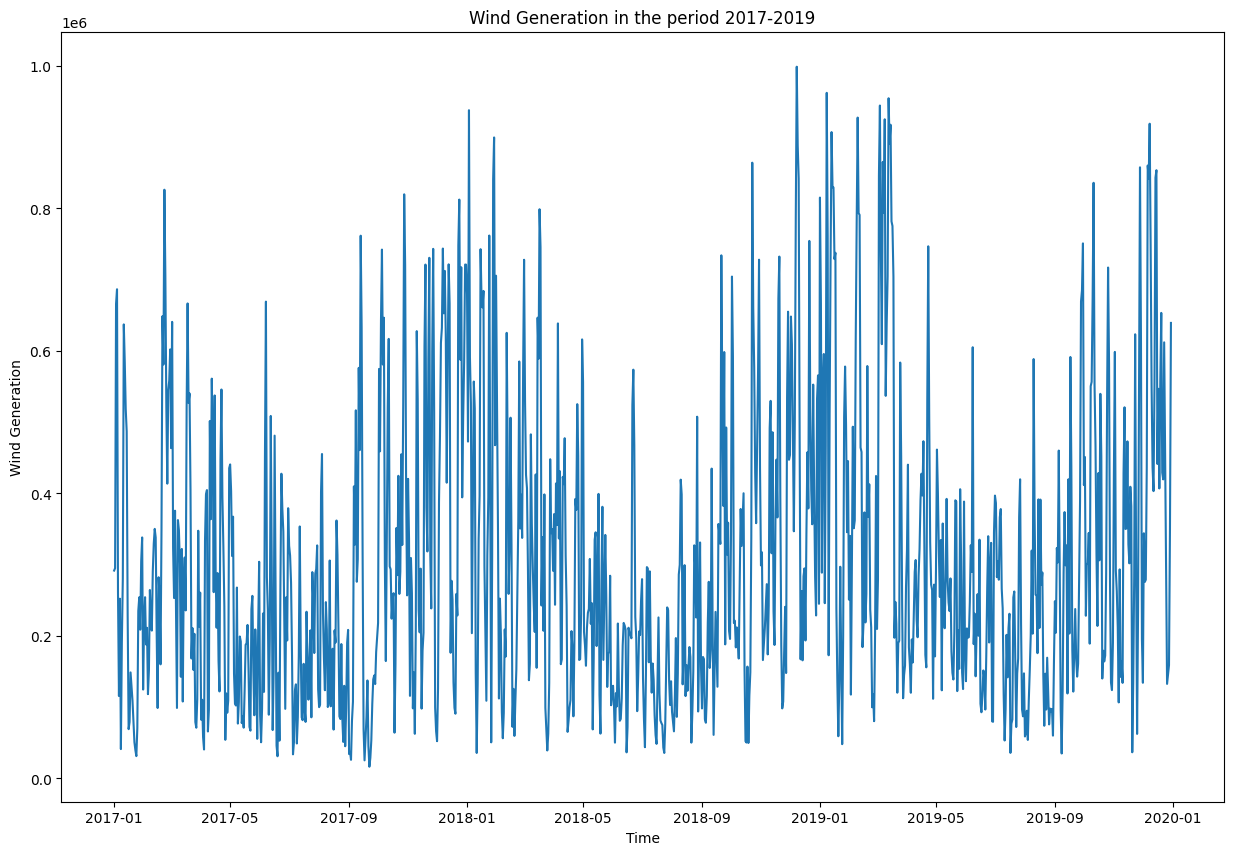

In [7]:
plt.figure(figsize=(15,10))
sns.lineplot(data= wind_energy, x='utc_timestamp', y='wind_generation_actual')
plt.ylabel("Wind Generation")
plt.xlabel("Time")
plt.title("Wind Generation in the period 2017-2019")
plt.show()

From here it can be seen that in all three years, the summer season (May to September) has the lowest wind generation while the winter season (September to April) has the highest. There is a certain seasonality in the data, visible from the recurring patterns, and probably also a cyclical component.

**B. Wind_Capacity**

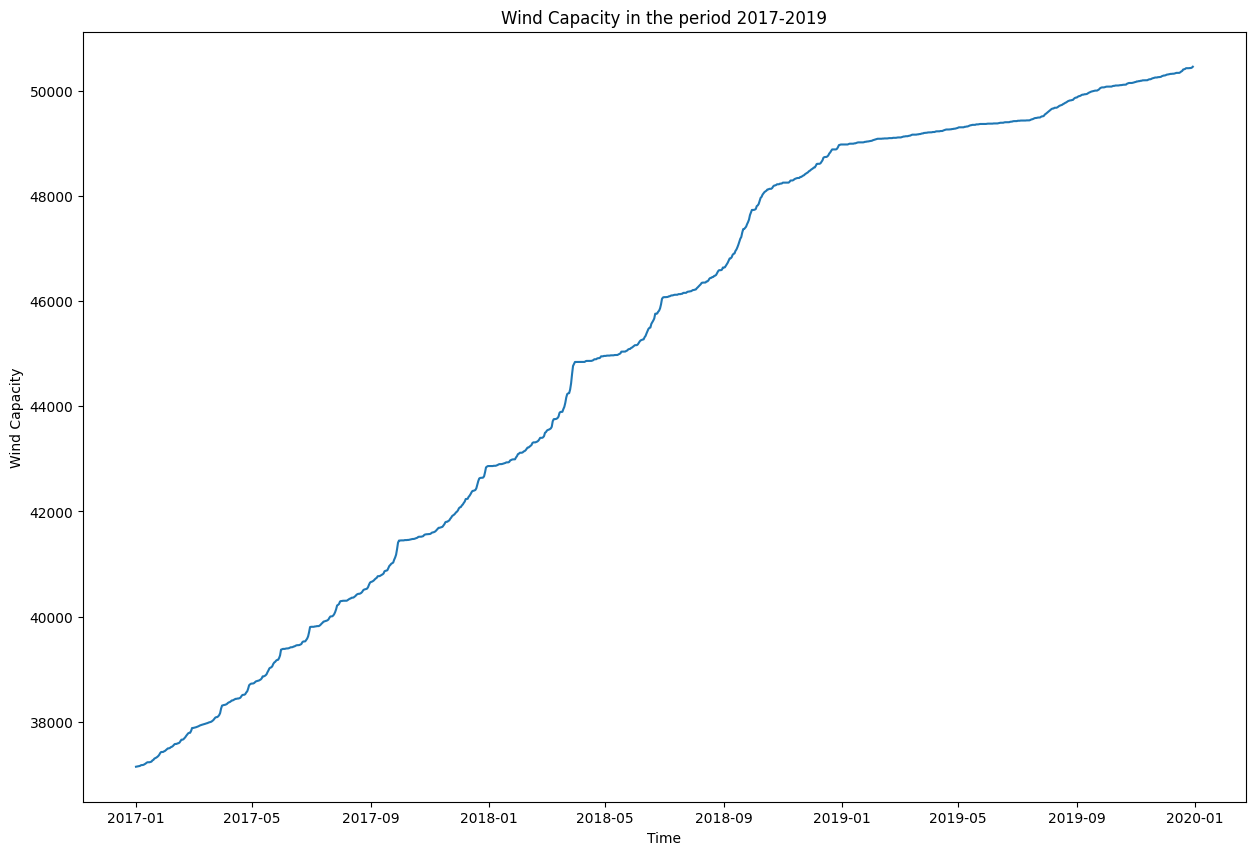

In [8]:
plt.figure(figsize=(15,10))
sns.lineplot(data=wind_energy, x='utc_timestamp', y='wind_capacity')
plt.ylabel("Wind Capacity")
plt.xlabel("Time")
plt.title("Wind Capacity in the period 2017-2019")
plt.show()


From this graph, however, it can be seen that there is a recurring 'wave' pattern that starts fairly slowly in 2017, but laver, between the ylast two years, the waves become a little longer and higher.

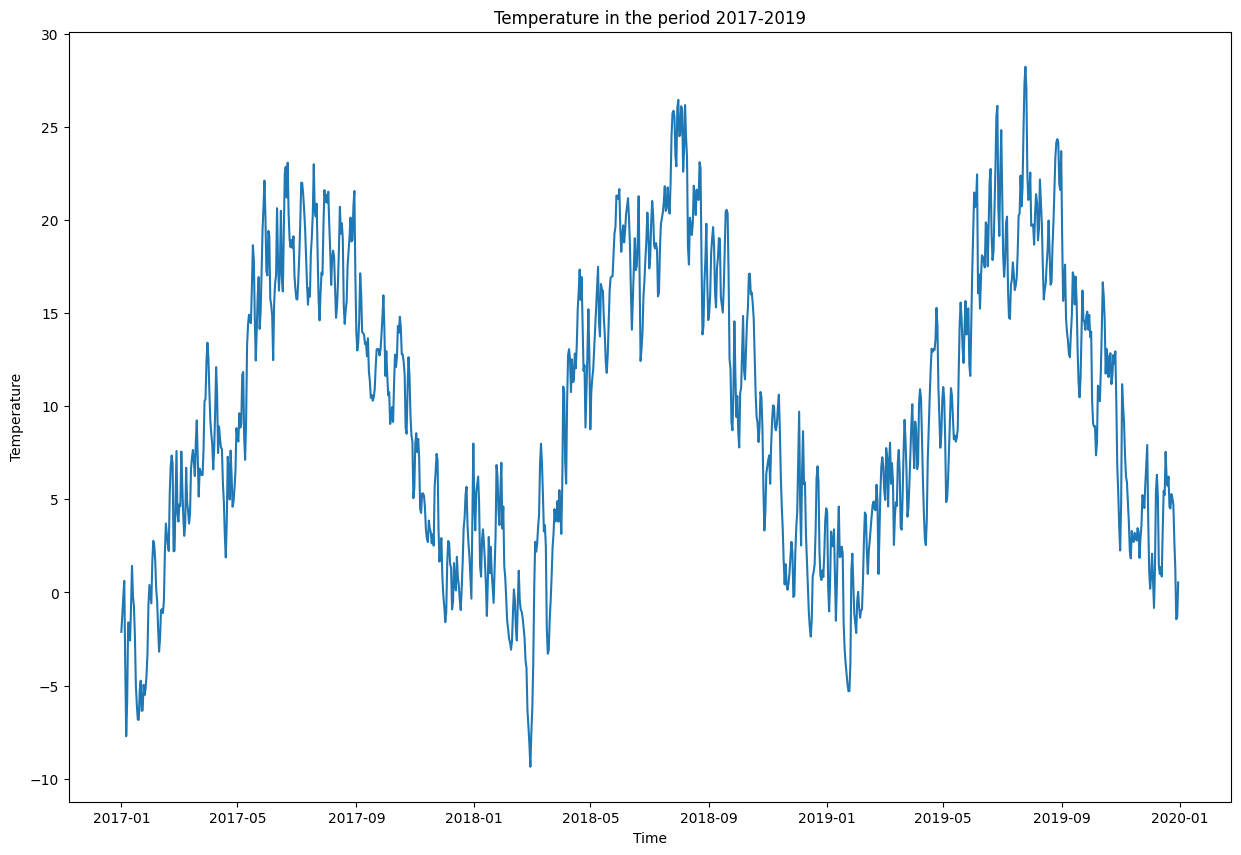

In [9]:
plt.figure(figsize=(15,10))
sns.lineplot(data = wind_energy, x='utc_timestamp', y='temperature')
plt.ylabel("Temperature")
plt.xlabel("Time")
plt.title("Temperature in the period 2017-2019")
plt.show()

This graph shows the temperature trend over the last three years, highlighting a recurring seasonal pattern, which can be seen from the three ‘peaks’. Each year, temperatures are lowest in the winter months, gradually rise in the spring until they peak in the summer, then fall again in the autumn and return to their lowest values in the winter. This cycle repeats itself regularly, indicating a marked climatic seasonality.

Next, we will analyse the distribution of the variables by means of a *histogram* graph

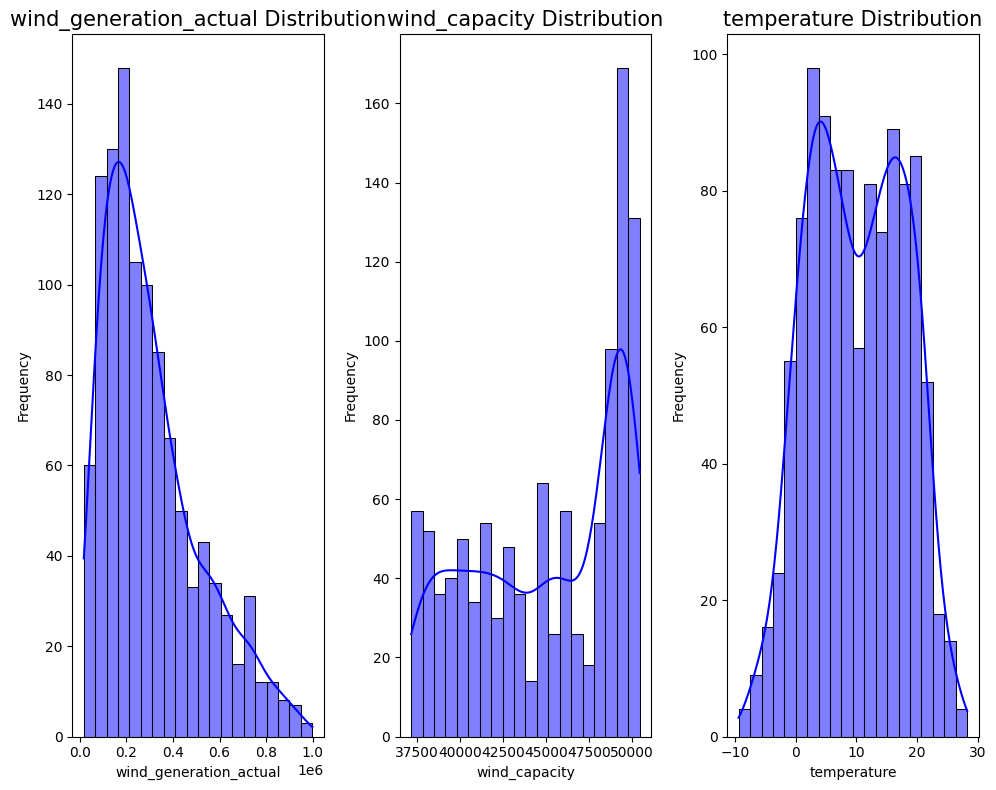

In [10]:
variables = wind_energy.columns
n_vars = len(variables)
fig, axes = plt.subplots(1,3,figsize=(10,8))
for i, var in enumerate(variables):
    sns.histplot(wind_energy[var], bins=20, kde=True, ax=axes[i], color='Blue')
    axes[i].set_title(f'{var} Distribution', fontsize=15)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

Next, we visualise the distribution of variables and the presence of outliers using a *Boxplot* and *Violinplot* graph.

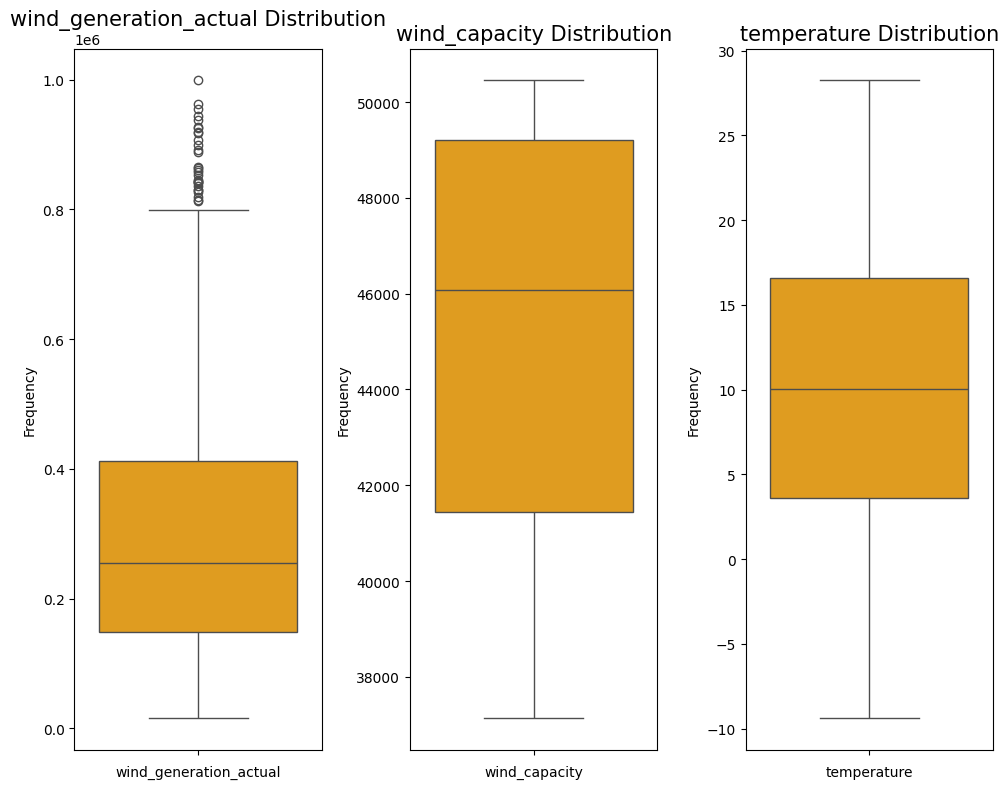

In [11]:
fig, axes = plt.subplots(1,3,figsize=(10,8))
for i, var in enumerate(variables):
    sns.boxplot(y=wind_energy[var], ax=axes[i], color='Orange')
    axes[i].set_title(f'{var} Distribution', fontsize=15)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

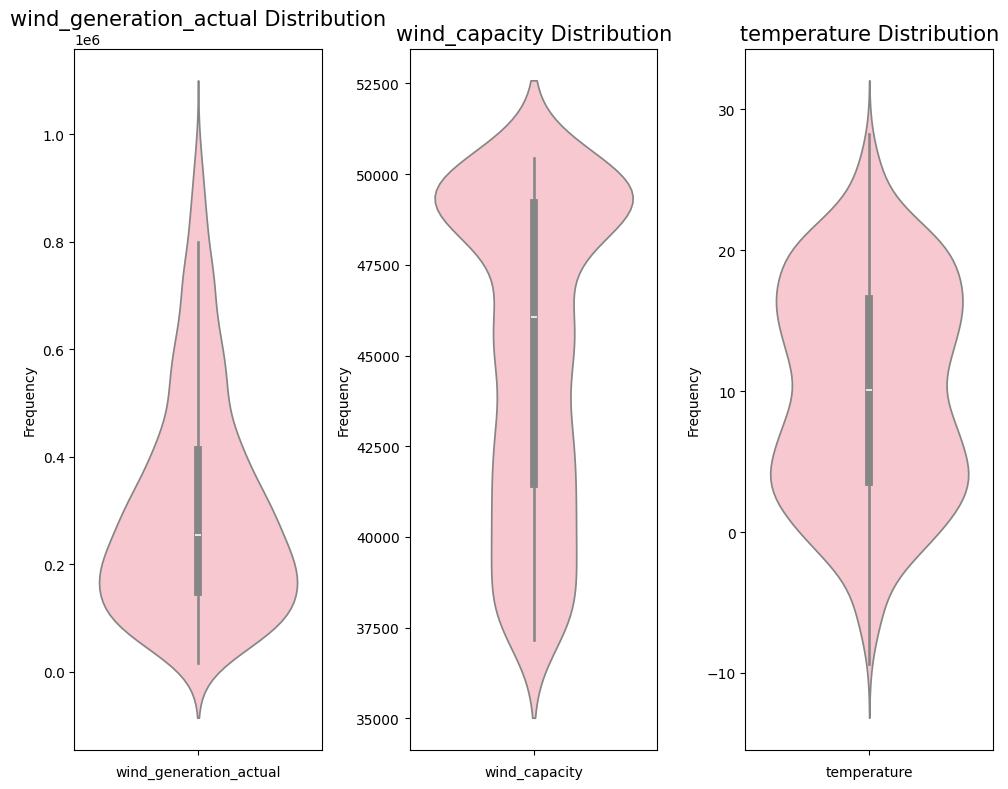

In [12]:
fig, axes = plt.subplots(1,3,figsize=(10,8))
for i, var in enumerate(variables):
    sns.violinplot(y=wind_energy[var], ax=axes[i], color='Pink')
    axes[i].set_title(f'{var} Distribution', fontsize=15)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

We see that there are some outliers in the wind generation. Let's investigate more by calculating the *IQR* and then determine the total numbers of outliers.

In [13]:
Q1_py = np.quantile(wind_energy.wind_generation_actual,0.25)
Q3_py = np.quantile(wind_energy.wind_generation_actual,0.75)
IQR = Q3_py-Q1_py
Lower_Fence = Q1_py - 1.5*IQR
Upper_Fence = Q3_py + 1.5*IQR

T = []
for i in wind_energy.wind_generation_actual:
    exp1 = i < Lower_Fence
    exp2 = i > Upper_Fence
    if exp1 or exp2:
       temp = i
       T.append(temp)
print('The total number of outliers is ', len(T), 'which is rougly', round(len(T)/len(wind_energy)*100,2), '% of the dataset')

The total number of outliers is  30 which is rougly 2.74 % of the dataset


Another interesting thing to see is if there is correlations between the variables with the *Heatmap*. This will be useful in determining the type of model we are going to use to forecast data.

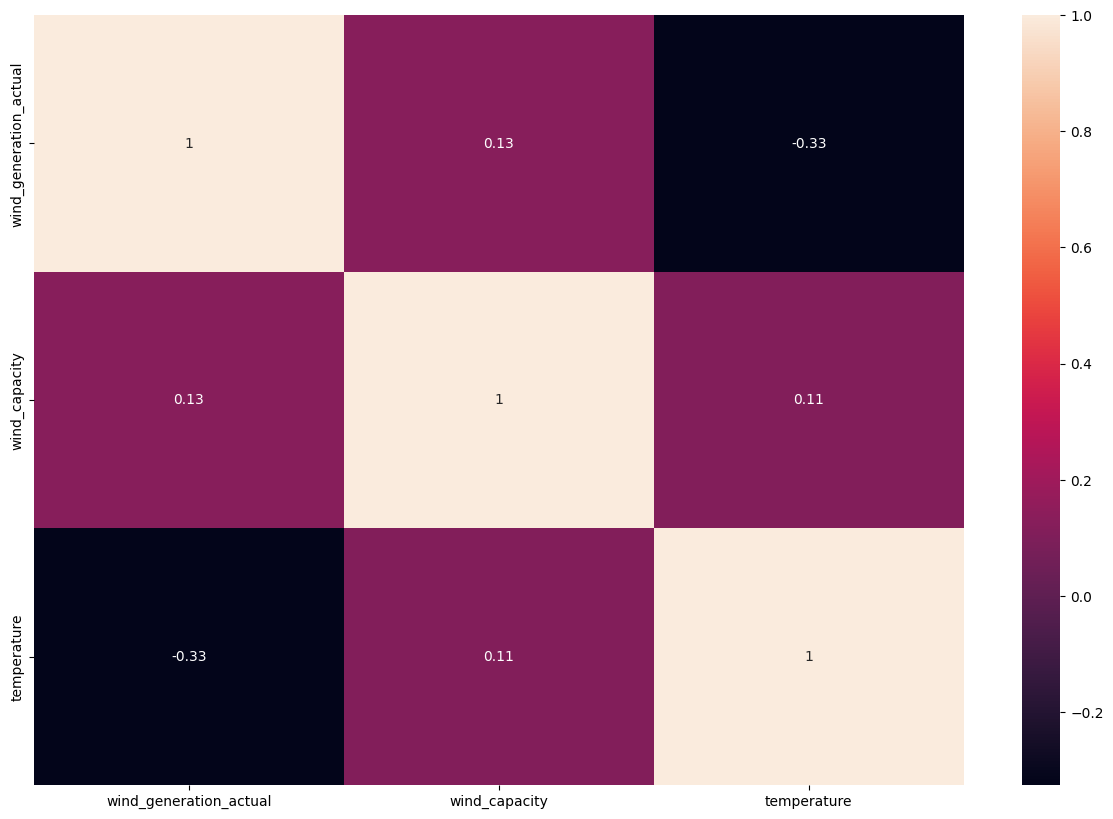

In [14]:
plt.figure(figsize=(15,10))
corr = wind_energy.corr()
sns.heatmap(corr,annot=True)
plt.show()

It's possible to see that the data does not present strong correlation between the features. There is a slighly negative correlation between the wind_generation and the temperature. 

**SLIPT OF THE DATA**

From the document 'The main aim of this project is to forecast the wind power generation for the last month of 2019 (December)'. So the test set is going to be only the month of december 2019 and the train set will be the other part.

In [15]:
#Splitting the data in the train and test set. The month of december 2019 is going to be out test set.
train_data = wind_energy[:'2019-12-01']
test_data = wind_energy['2019-12-01':]
wind_generation_train = wind_energy['wind_generation_actual'][:'2019-12-01']
wind_generation_test = wind_energy['wind_generation_actual']['2019-12-01':]

print('Shape of the splotted dataset: ', '\nTrain: ', wind_generation_train.shape, '\nTest: ', wind_generation_test.shape)
print(wind_generation_train.head())
print(wind_generation_test.head())

Shape of the splotted dataset:  
Train:  (1065,) 
Test:  (30,)
utc_timestamp
2017-01-01 00:00:00+00:00    291760.0
2017-01-02 00:00:00+00:00    295097.0
2017-01-03 00:00:00+00:00    666170.0
2017-01-04 00:00:00+00:00    686581.0
2017-01-05 00:00:00+00:00    261759.0
Freq: D, Name: wind_generation_actual, dtype: float64
utc_timestamp
2019-12-01 00:00:00+00:00    134296.0
2019-12-02 00:00:00+00:00    344119.0
2019-12-03 00:00:00+00:00    275830.0
2019-12-04 00:00:00+00:00    278977.0
2019-12-05 00:00:00+00:00    436209.0
Freq: D, Name: wind_generation_actual, dtype: float64


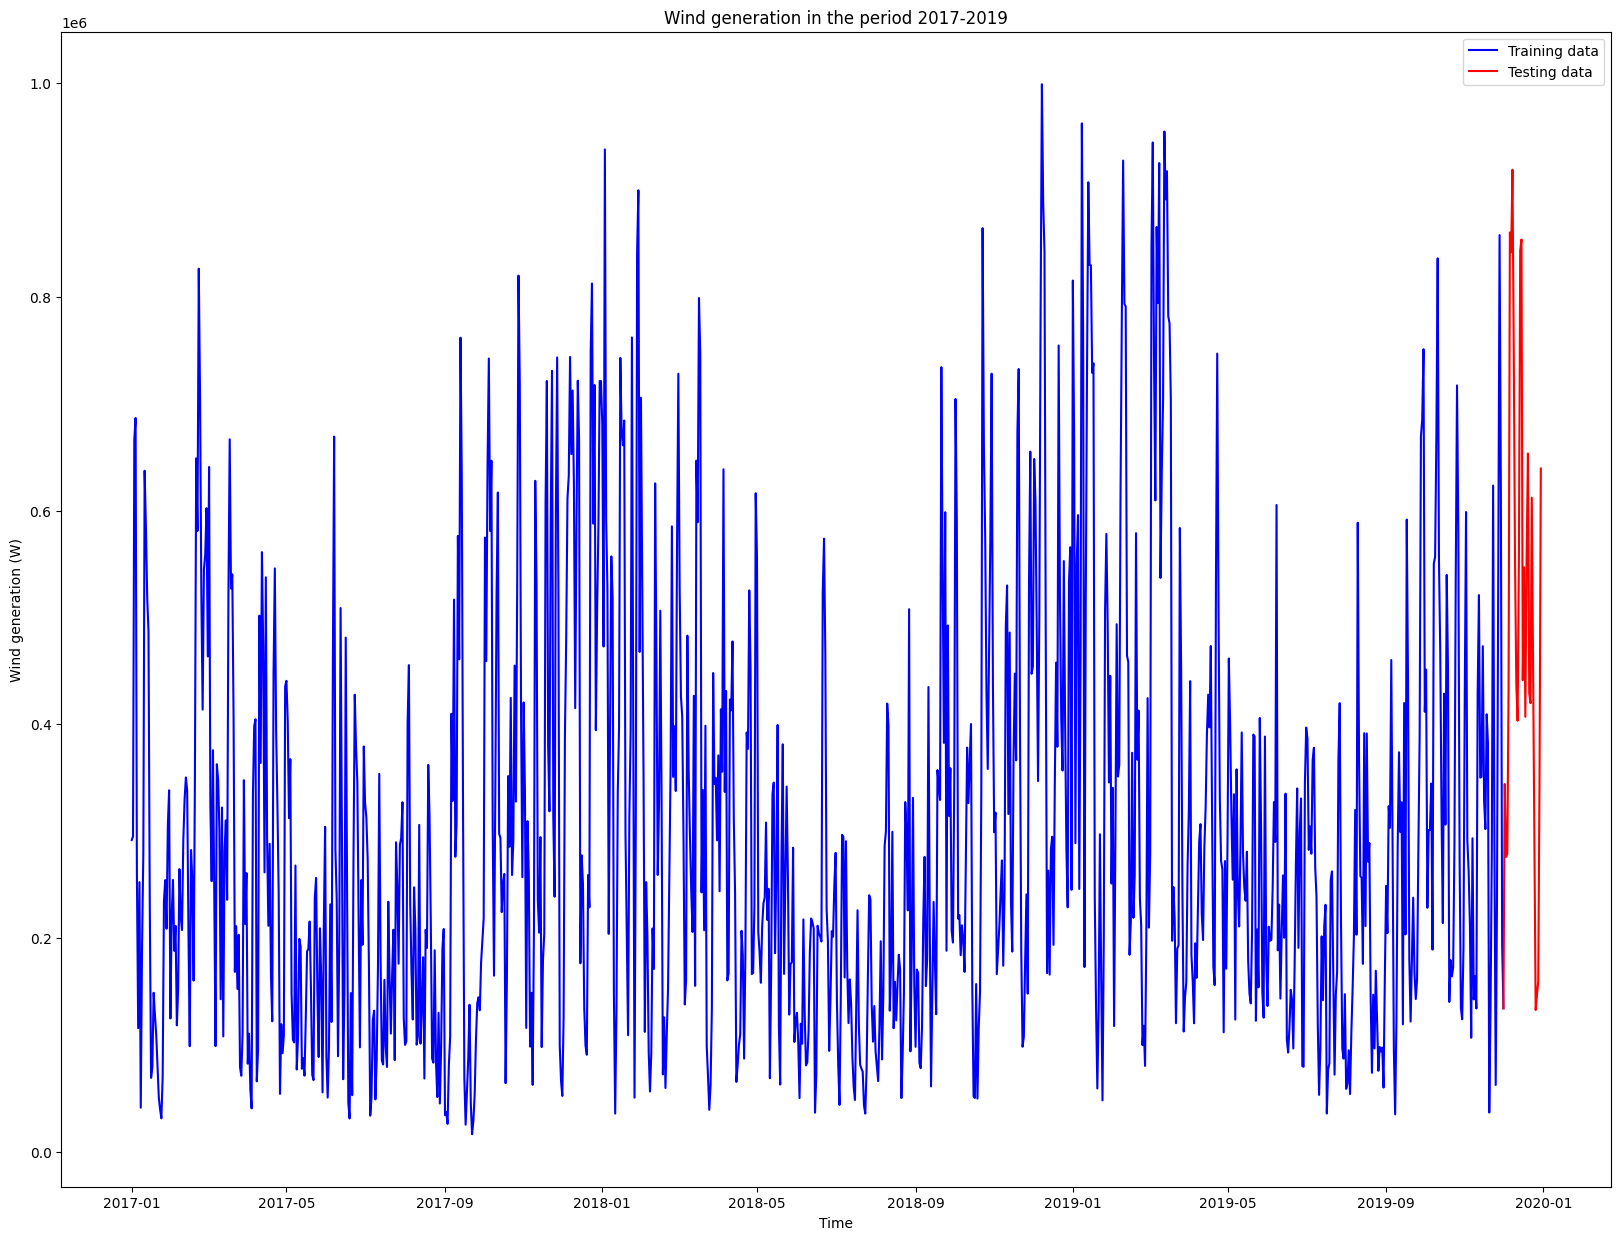

In [16]:
#Replot of the data we are intersted in forecasting.
plt.figure(figsize=(20,15))
plt.plot(train_data['wind_generation_actual'], color = 'blue', label='Training data')
plt.plot(test_data['wind_generation_actual'], color = 'red', label='Testing data')
plt.ylabel("Wind generation (W)")
plt.xlabel('Time')
plt.title("Wind generation in the period 2017-2019")
plt.legend()
plt.show()

**APPROACH METHOD**

- Check for stationarity of the data
- Determine the seasonality of the data
- Make the data stationary by applying differenciation
- Perform ACF and PACF analysis to gather the parameters dor the model part
- Train the models and get the predictions
- Compare the models used by MAE, MSE and AIC.

**STATIONARITY**

In time series analysis, many modelling techniques assume that the data are stationary. A time series is stationary when its statistical characteristics (mean, variance, autocorrelation) do not change over time.
To determine if our data is stationary or not we have to use the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) and the ADFuller tests which have different hypothesis and can be done separated.

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adfuller_test(series):
    adf_test = adfuller(series, autolag='AIC') #AIC is the default option
    print('ADF Statistic is:', adf_test[0])
    print('p-value is:', adf_test[1])
    print('Critical value is:', adf_test[4])
    if adf_test[1] <= 0.05:
        print('We can reject the null hypothesis (HO). So the data is stationary')
    else:
        print('We can NOT reject the null hypothesis (H0). So the data is NOT stationary')

def kpss_test(series):
    kpss_result = kpss(series, regression='ct', nlags='auto', store=True)
    print('KPSS Statistic is:', kpss_result[0])
    print('p-value is:', kpss_result[1])
    if kpss_result[1] <= 0.05:
        print('We can reject the null hypothesis (HO). So the data is NOT trend stationary')
    else:
        print('We can NOT reject the null hypothesis. So the data is stationary')
 


In [18]:
adfuller_test(wind_generation_train)
kpss_test(wind_generation_train)

ADF Statistic is: -10.77088114757016
p-value is: 2.3860555693459754e-19
Critical value is: {'1%': -3.436528314312484, '5%': -2.86426792284943, '10%': -2.568222448164332}
We can reject the null hypothesis (HO). So the data is stationary
KPSS Statistic is: 0.16055636659786887
p-value is: 0.037869694501775936
We can reject the null hypothesis (HO). So the data is NOT trend stationary


In the ADFuller test, the p-value is less than 0.05, so we can reject the null hypothesis and the data is stationary. 
But for the KPSS test, the p-vale is less that 0.05, so we can reject the null hyppthesist, so the data is NON trend stationary and so we have to do some differencing to get the stationary; it's usually adviced to remuve first the seasonality part and then do the differencing.

**FREQUENCY ANALYSIS**

   Frequency       Density      Period
0   0.002817  6.622174e+12  355.000000
1   0.006573  1.146676e+11  152.142857
2   0.011268  3.955245e+11   88.750000
3   0.014085  1.126715e+11   71.000000
4   0.015962  1.434301e+11   62.647059


Text(0, 0.5, 'Power')

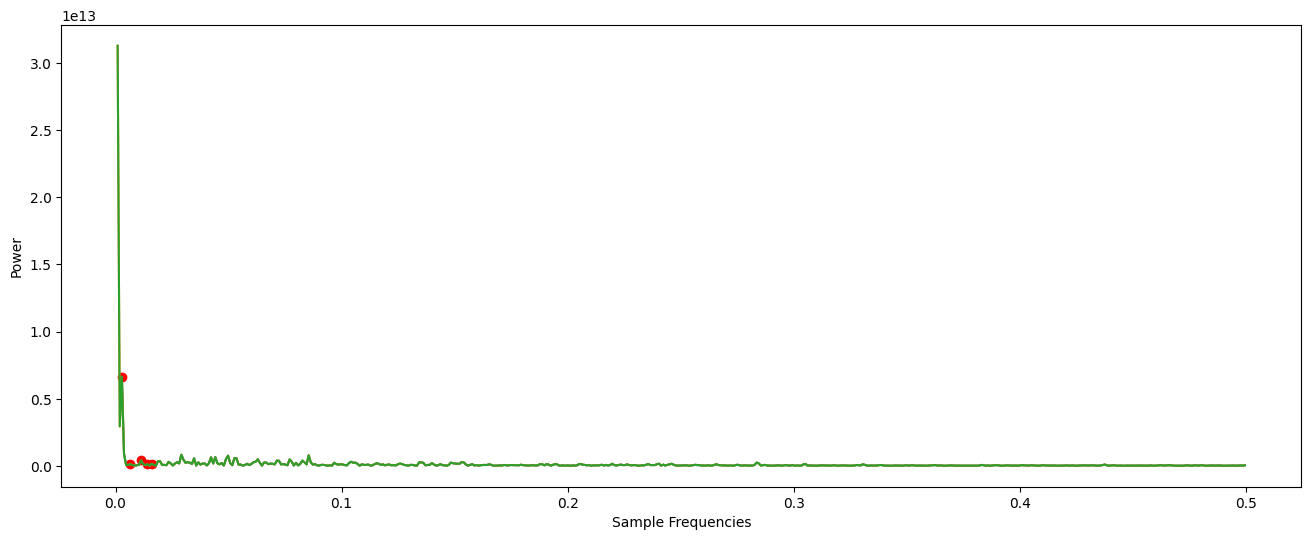

In [19]:
###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
f_per, Pxx_per = signal.periodogram(wind_generation_train,1,detrend=None,window='hann',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))

plt.plot(peak_freq[:5], peak_dens[:5], 'ro');
plt.plot(f_per[2:],Pxx_per[2:])

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data)

print(df.head())
sns.lineplot(x=f_per,y=Pxx_per)
plt.plot(f_per, Pxx_per)
plt.xlabel('Sample Frequencies')
plt.ylabel('Power')

We see that the most highest frquencies represents the periods 355, 152, 88, 71 and 62 days. So we have five guesses for the seasonalities, it's common that a time series has more than one seasonality. For mine purpose i'll use the seasonality of 355 approximated to 365 (yearly seasonality) and then the 88 approximated do 90 (three month seasonality.)

**APPLY SEASONAL DIFFERENCE TO OUR DATA**

Since the data is not stationary, we have to do a difference on the starting dataset. From the spectral analysis we have that the most recurrent period is 355, which can be seen as yearly seasonality.
So, we are going to do a difference of 365 to the data and then test if it is stationary.

Text(0.5, 1.0, 'Wind Energy Generation diffed 365')

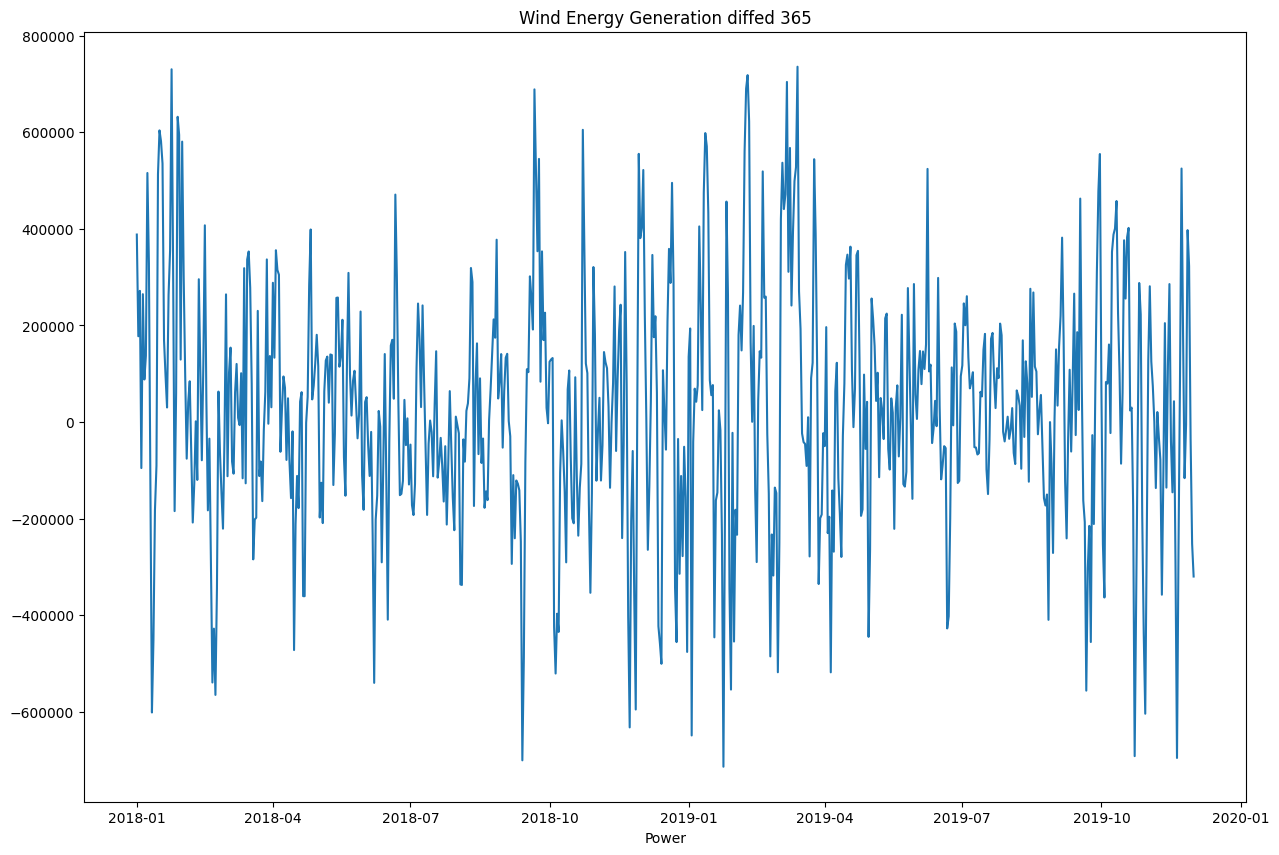

In [20]:
wind_generation_diff_train = wind_generation_train.diff(365).dropna()
train_data_diff = train_data.diff(365).dropna()
plt.figure(figsize=(15,10))
plt.plot(wind_generation_diff_train)
plt.xlabel('Power')
plt.title('Wind Energy Generation diffed 365')

We now apply the stationary test to see if this is enough to make our data stationary.

In [21]:
adfuller_test(wind_generation_diff_train)
kpss_test(wind_generation_diff_train)

ADF Statistic is: -13.767585382019107
p-value is: 9.818651975747313e-26
Critical value is: {'1%': -3.439753311961436, '5%': -2.8656896390914217, '10%': -2.568979777013325}
We can reject the null hypothesis (HO). So the data is stationary
KPSS Statistic is: 0.06629966536457012
p-value is: 0.1
We can NOT reject the null hypothesis. So the data is stationary


Now, the data is stationary!

**ACF and PACF**

The autocorrelation measures the linear relationship between lagged values of a time series. The tools that can be used to detect the properties of time series are the *ACF* and *PACF*, the AutoCorrelation Function and the Partial AutoCorrelation Function, respectively; the term auto refers to the fact that the correlation concerns the same data and not different sets. 

In [22]:
#for ACF plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

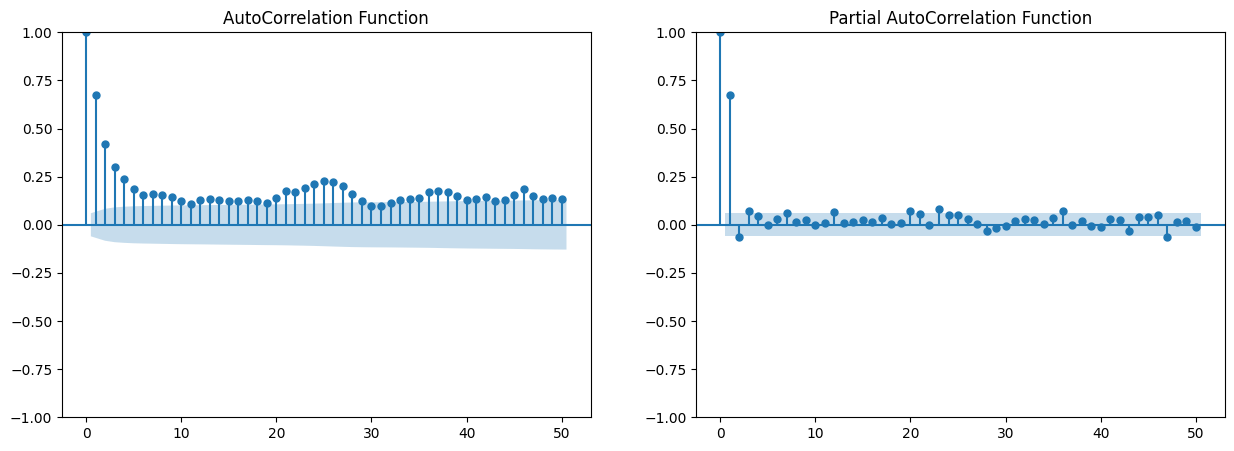

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(wind_generation_train, lags=50, ax=ax[0], title='AutoCorrelation Function')
plot_pacf(wind_generation_train, lags=50, ax=ax[1], title='Partial AutoCorrelation Function')
plt.show()

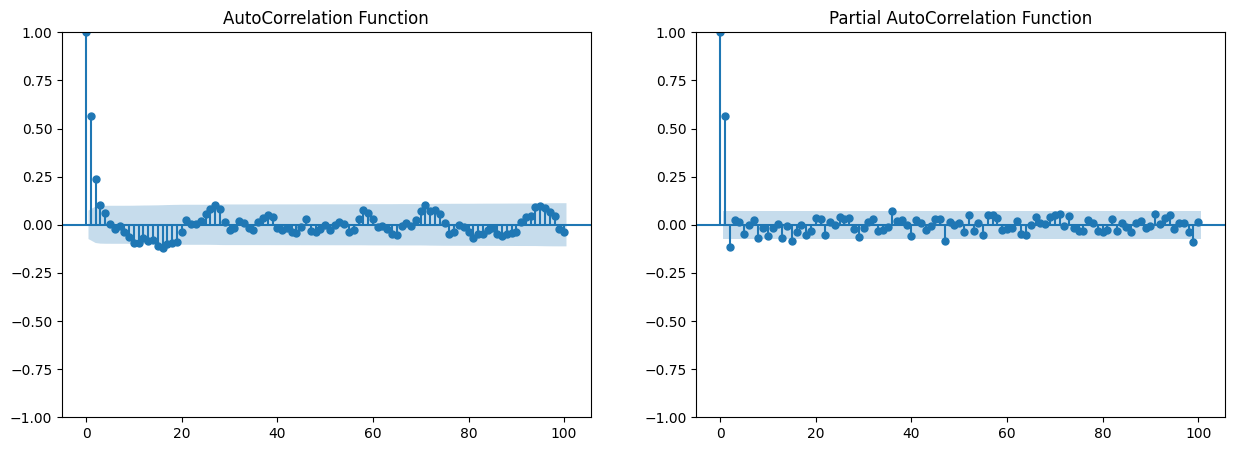

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(wind_generation_diff_train, lags=100, ax=ax[0], title='AutoCorrelation Function')
plot_pacf(wind_generation_diff_train, lags=100, ax=ax[1], title='Partial AutoCorrelation Function')
plt.show()

In the first case there are many outliers that lie outside the ‘confidence interval’ and this means that many data at different lags are correlated with each other, which is not the case in the second case after differentiation of the data.

**COINTEGRATION**

The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the p-value is small, below a critical size, then we can reject the hypotheiss that there is no cointegrating relationship.

In [25]:
score, p_value, crit_val = st.coint(wind_energy['wind_generation_actual'], wind_energy['temperature'], maxlag=20)
print('p-value for cointegration test is:', p_value)

p-value for cointegration test is: 1.0248699690744369e-27


The p-value is very lower than the critical value, so we can reject the null hypothesis.

**PROBLEM:**
Such a large seasonality is a huge problem for the Sarima model. To solve this problem, I decided to do a data processing and then use a transformation of the daily data into weekly or monthly data using an aggregation function.

**MATRICS TABLE**

I've decide to used a dataframe to save all the values and properties of each model.

In [26]:
metrics_df = pd.DataFrame(columns= ['Model_name', 'AIC', 'MAE', 'RMSE', 'MAPE'])
display(metrics_df)

,Model_name,AIC,MAE,RMSE,MAPE


**MODELS**

First of all, I consider a different sampling of the data, so all data are grouped on a weekly basis against the average of all seven days of a week.

In [27]:
weekly_wind_energy = wind_energy.resample('1W').mean()
print("The new Dataset shapel is:", weekly_wind_energy.shape)

The new Dataset shapel is: (158, 3)


Having grouped the data into weekly values, the test set results in only 4 monthly values as opposed to 30 in the daily case. Therefore, for my purpose, I will use the last three months for the test set.

In [28]:
data_train = weekly_wind_energy['wind_generation_actual'][:-13]
data_test = weekly_wind_energy['wind_generation_actual'][-13:]
display(data_train.shape)
display(data_test.shape)

(145,)

(13,)

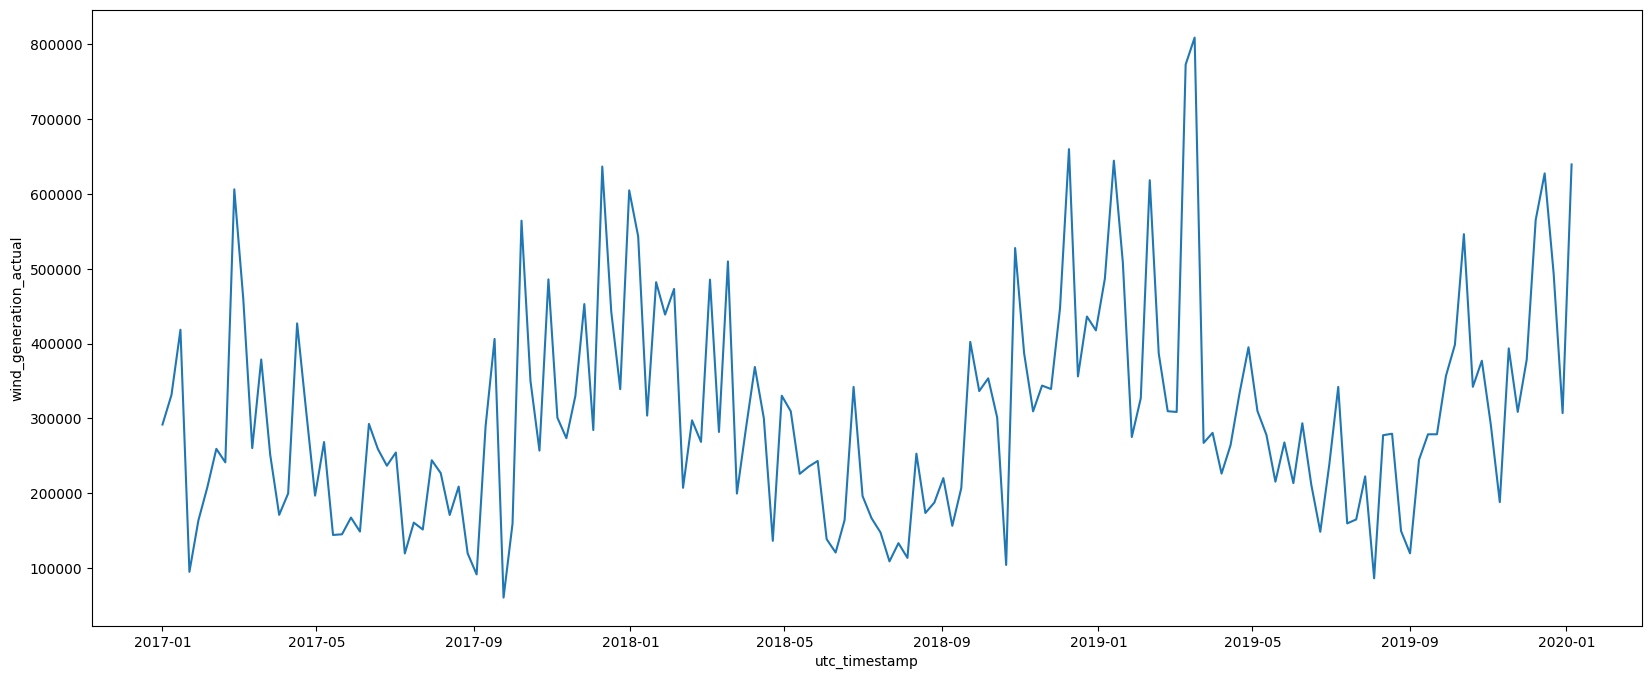

In [29]:
plt.figure(figsize=(20,8))
sns.lineplot(weekly_wind_energy, x='utc_timestamp', y='wind_generation_actual')
plt.show()

**Stationary test on Weekly Data:** We now perform the stationarity test to see if the data is non-stationary.


In [30]:
adfuller_test(data_train)
kpss_test(data_train)

ADF Statistic is: -2.2550841820415495
p-value is: 0.18686345881574162
Critical value is: {'1%': -3.4782936965183815, '5%': -2.882567574015525, '10%': -2.5779830117488745}
We can NOT reject the null hypothesis (H0). So the data is NOT stationary
KPSS Statistic is: 0.08445163186979439
p-value is: 0.1
We can NOT reject the null hypothesis. So the data is stationary


The ADFuller tell us that the time series is non-stationary and the KPSS test says that the time seris is stationary. So the time series is stationary by difference and it requires a differentiation.

   Frequency       Density     Period
0   0.020690  8.157474e+11  48.333333
1   0.048276  1.256319e+10  20.714286
2   0.062069  2.829531e+09  16.111111
3   0.082759  3.568376e+10  12.083333
4   0.096552  1.521905e+10  10.357143


Text(0, 0.5, 'Power')

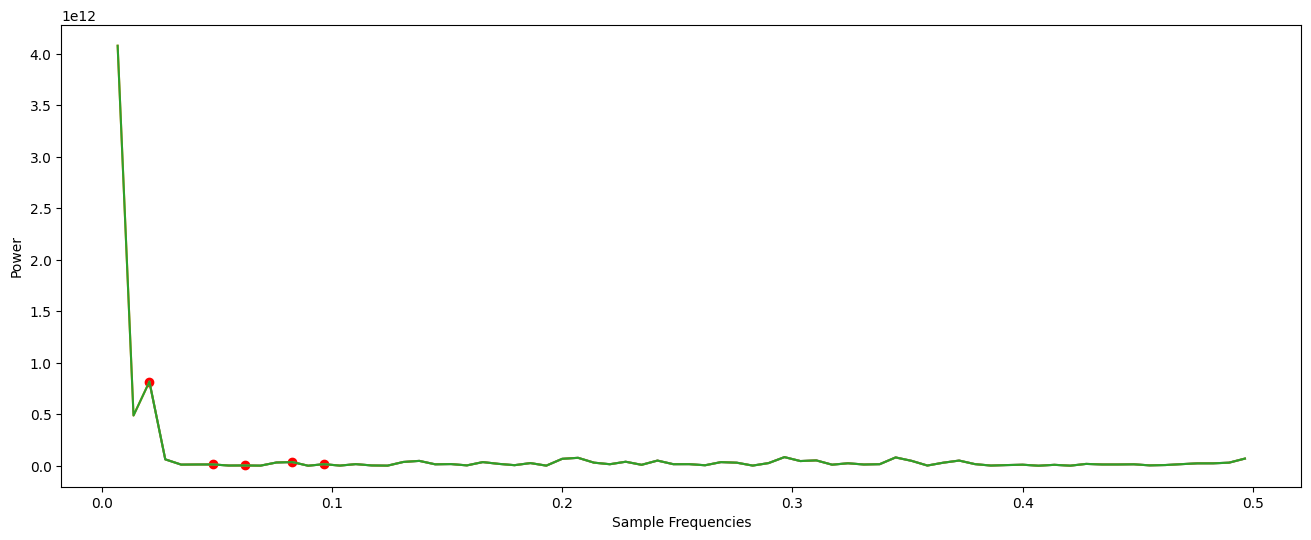

In [31]:
f_per, Pxx_per = signal.periodogram(data_train,1,detrend=None,window='hann',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))

plt.plot(peak_freq[:5], peak_dens[:5], 'ro');
plt.plot(f_per[2:],Pxx_per[2:])

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data)
print(df.head())
sns.lineplot(x=f_per,y=Pxx_per)
plt.plot(f_per, Pxx_per)
plt.xlabel('Sample Frequencies')
plt.ylabel('Power')

We proceed to remove the seasonality, that we have caluclated before.

In [32]:
data_train_diff = data_train.diff(52).dropna()
adfuller_test(data_train_diff)
kpss_test(data_train_diff)

ADF Statistic is: -8.74915804531474
p-value is: 2.8678153797582635e-14
Critical value is: {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
We can reject the null hypothesis (HO). So the data is stationary
KPSS Statistic is: 0.127799946431593
p-value is: 0.08370380290445738
We can NOT reject the null hypothesis. So the data is stationary


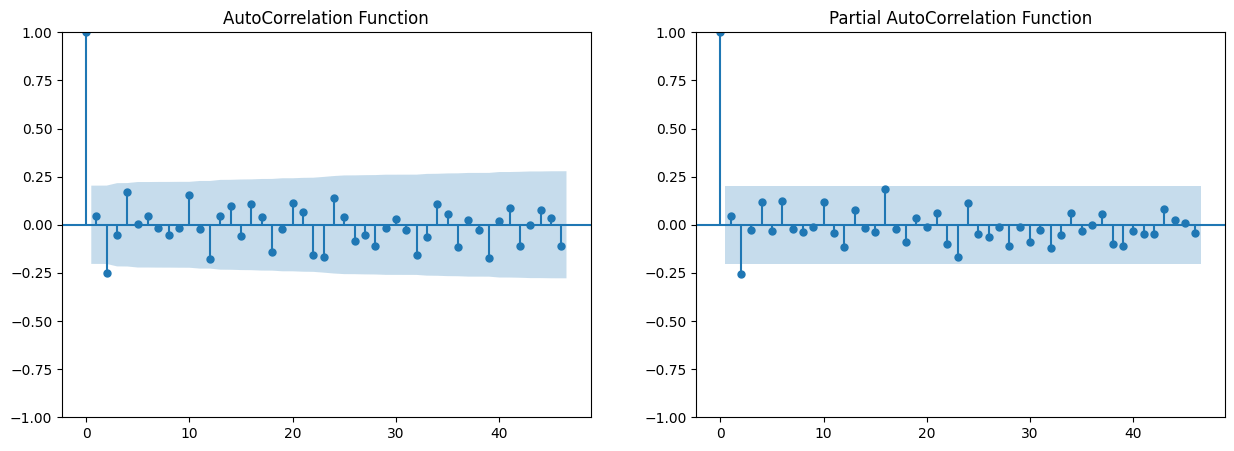

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(data_train_diff, lags=46, ax=ax[0], title='AutoCorrelation Function')
plot_pacf(data_train_diff, lags=46, ax=ax[1], title='Partial AutoCorrelation Function') #Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 48 must be < 46.
plt.show()

There is NOT a lot of autocorrelation of the data, we can see two little spikes at lags 2 in ACF and PACF, but other tham that we can't deduce better results.

**1. MANUAL SARIMA**

When dealing with the family of ARIMA models, it is important to remember the Box-Jenkins methodology. This refers to a systematic method of identifying, fitting, checking, and using ARIMA models built for time series forecasting.
1. Model identification: as first steo, it is important to verify the stationarity, determine if our time series is seasonal and find the seasonal period, and eventually apply appropriate transofrmations to reduce the variance. The next step is to identify the order (p,d,q) of ARIMA models in order to capture the salient dynamic features of the data. This is done by relying on ACF/PACF plots or on Grid Search.
2. Model Estimation: Once the model order has been identified, the model parameter are estimated. Appropriate criteria, such as AIC, have to be used to compare and select the best model
3. Model Diagnostic: After fitting the model in the train data, conduct goodness-of-fit checks to ensure the model describes the data adequately. In particular, the residuals are taken and it is assessed whether they are White Noise and they are normally distributed. If model is appropriate for the data, the residuals should satisfy these assumptions. If they are not satisfied, we have to go back to the model identification step and try to develop a better model.
4. Forecasting: If the model is good, we can finally perform the forcasting analyses in the separate test set, and perform all the performance evaluations (MAE, MSE/RMSE, NAPE, R2)

In [34]:
(p, d, q)=(1, 0, 1)
S=52
D=1

To check the best values of the P and Q parameters for a SARIMAX model, we need to minimize the Akaike criteria (AIC)

In [34]:
#DO NOT RUN --> IT'S COMPUTATIONAL HEAVY!
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#import math
#best_aic = math.inf
#best_Q = 0
#best_P = 0 
#for P in range(0,4):
#    for Q in range(0,4):
#        model = SARIMAX(data_train, order=(p,d,q),
#                        seasonal_order=(P,D,Q,S),
#                        enforce_stationarity=False,
#                        enforce_invertibility=False)
#        result= model.fit(disp=False)
#        if result.aic<best_aic and (not np.isnan(result.bic) or not np.isnan(result.hqic)):
#            best_aic = result.aic
#            best_Q = Q
#            best_P = P

In [35]:
best_P = 1
best_Q = 1

In [36]:
best_manual_Sarima_model = SARIMAX(data_train,
                                   order=(p, d, q),
                                   seasonal_order=(best_P, D, best_Q, S),
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)

                                     SARIMAX Results                                      
Dep. Variable:             wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -1237.214
Date:                            Thu, 13 Feb 2025   AIC                           2484.428
Time:                                    11:24:38   BIC                           2497.091
Sample:                                01-01-2017   HQIC                          2489.541
                                     - 10-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1293      0.430     -0.301      0.764      -0.973       0.714
ma.L1          0.3669      0.397   

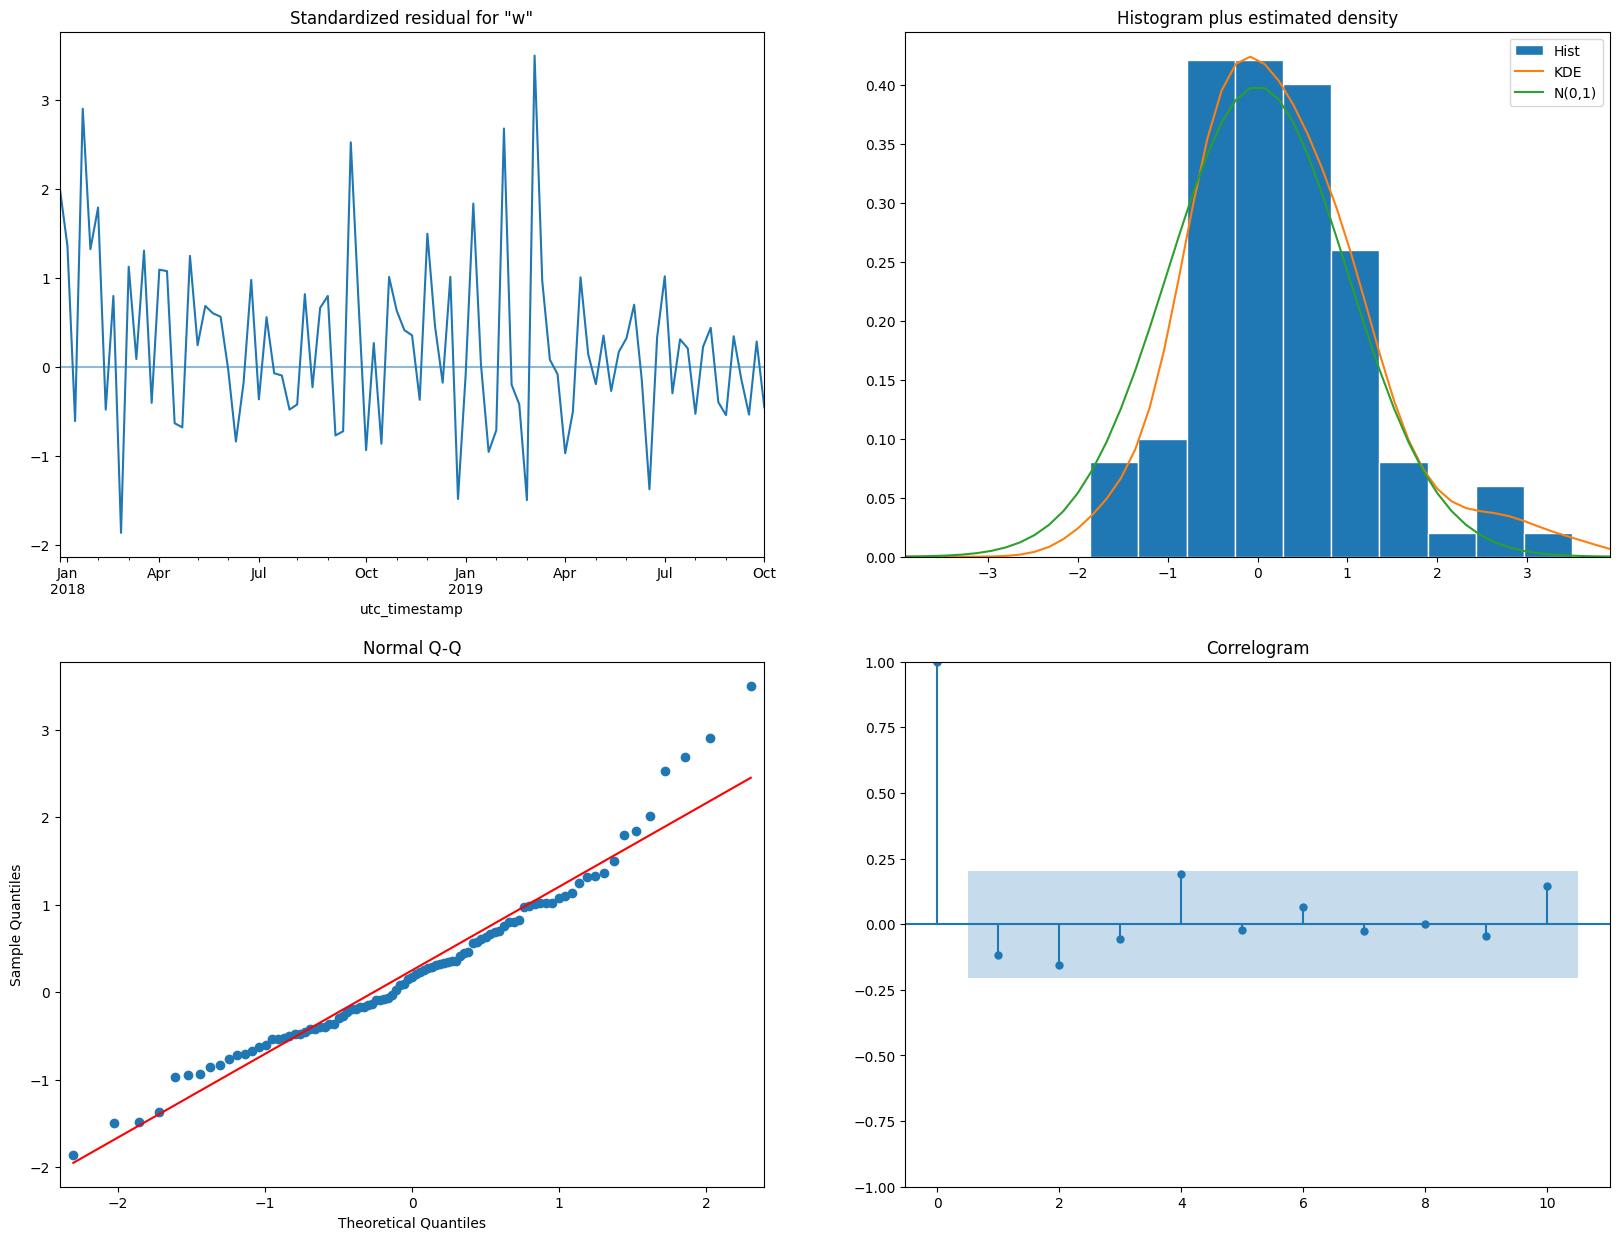

In [37]:
result_best_manual_Sarima = best_manual_Sarima_model.fit(disp=False)
print(result_best_manual_Sarima.summary())
result_best_manual_Sarima.plot_diagnostics(figsize=(20,15));

**Residual Test**

In [38]:
print('Durbin Watson: ', durbin_watson(result_best_manual_Sarima.resid))

Durbin Watson:  0.9952224796553998


A result which is lower than 2 means that the residual are positively correlated and this means that our model is not using all the available information from the data. It is possible to compute the Ljung-box test to see if it says different things

In [39]:
ljung_box_test = acorr_ljungbox(result_best_manual_Sarima.resid, period=52)
ljung_box_test.head()

,lb_stat,lb_pvalue
1,12.103766,5.032008e-04
2,21.772163,1.871695e-05
3,37.648399,3.354864e-08
4,64.323093,3.573161e-13
5,73.352701,2.052315e-14


**Prediction**

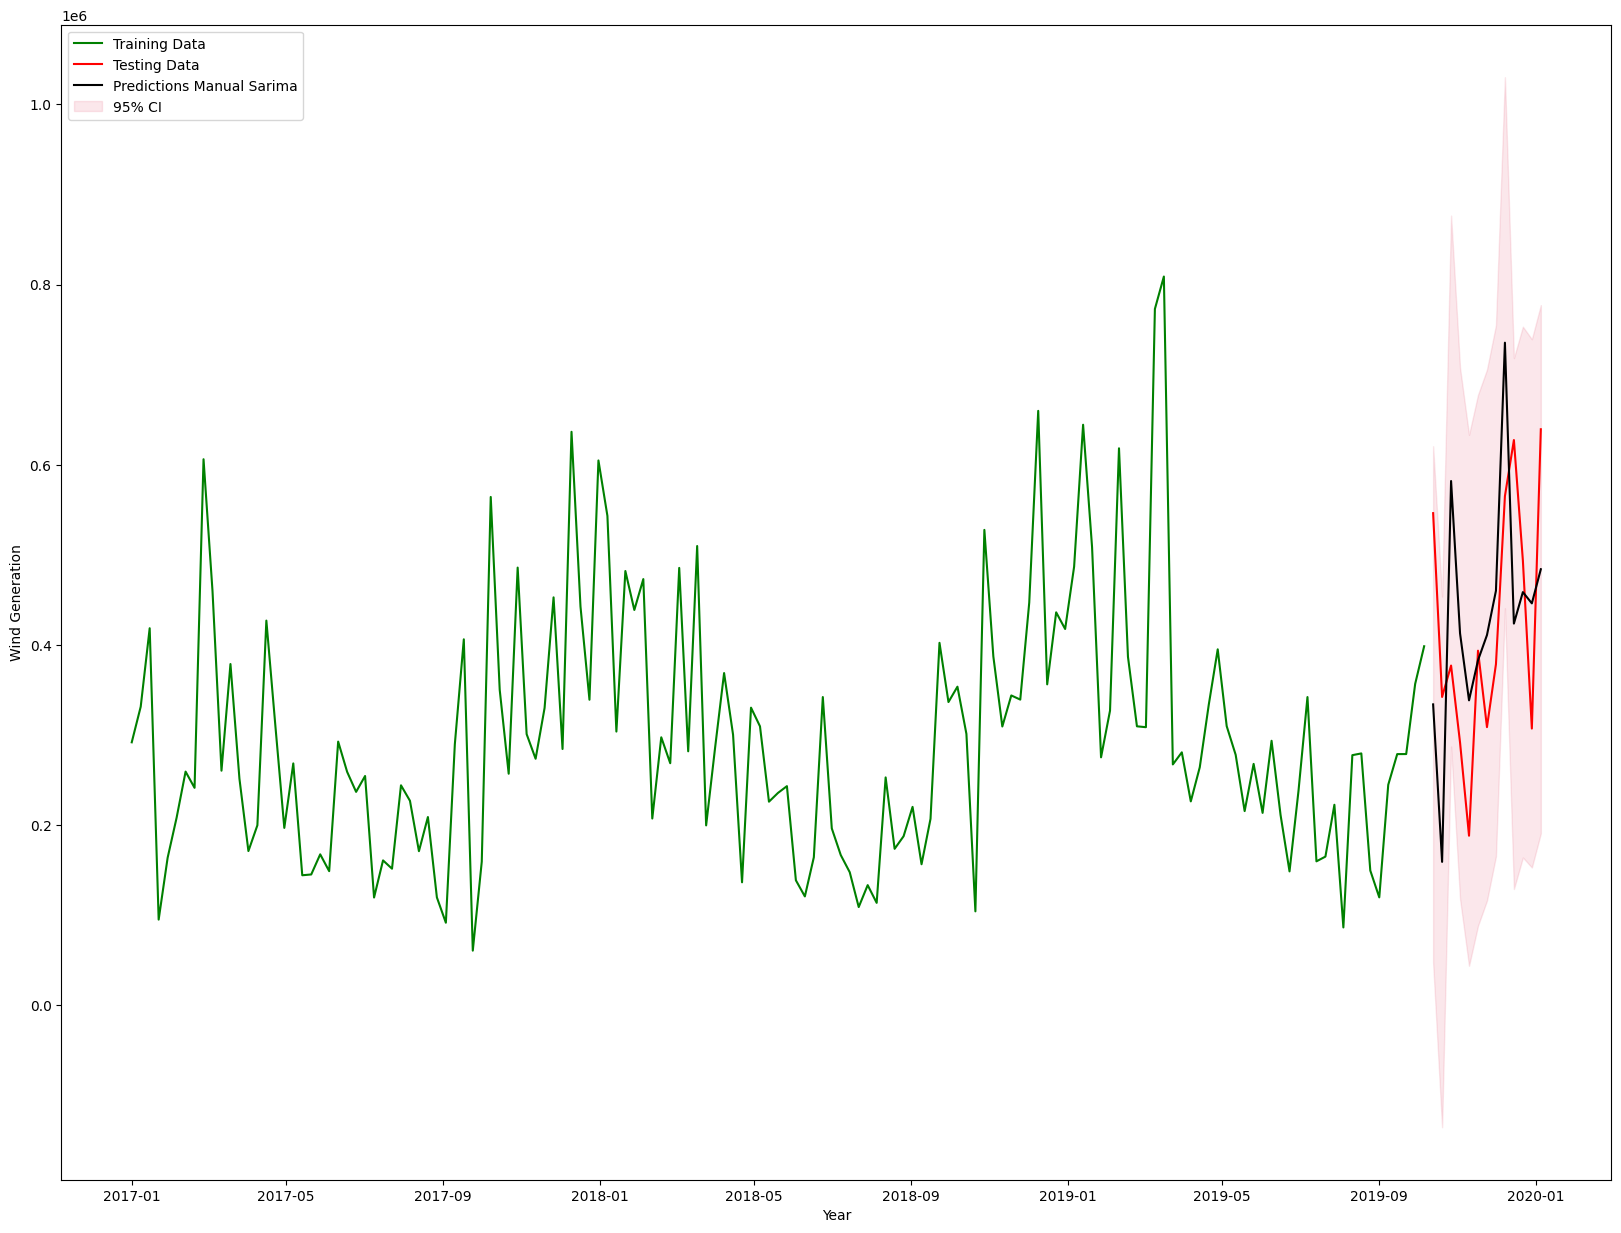

In [40]:
model_SARIMA = result_best_manual_Sarima.get_prediction(start=data_test.index[0], end=data_test.index[-1])
Sarima_df = model_SARIMA.summary_frame()
plt.figure(figsize=(20,15))
plt.plot(data_train, color='green', label='Training Data')
plt.plot(data_test, color='red', label='Testing Data')
plt.plot(Sarima_df['mean'], color='black', label='Predictions Manual Sarima')
plt.fill_between(Sarima_df.index, Sarima_df['mean_ci_lower'], Sarima_df['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Wind Generation')
plt.legend()
plt.show()

In [41]:
manual_sarima = pd.Series({'Model_name':'Sarima Manual', 'AIC': result_best_manual_Sarima.aic, 'RMSE': mean_squared_error(data_test, Sarima_df['mean'], squared=False), 
                           'MAE': mean_absolute_error(data_test, Sarima_df['mean']), 'MAPE': mean_absolute_percentage_error(data_test, Sarima_df['mean'])})
metrics_df = pd.concat([metrics_df, manual_sarima.to_frame().T])

Overall the result is not so bad, but it is possible to increase the performance of our model using the auto-sarima function from pmdarima.

**2. AUTO SARIMA**

We can clearly that the parameters are not the best ones and it can be seen in QQ plot. So we can determine the best parameters for the model using *auto arima*: this method search for the best parameters. We saw the grid search in the case of the arima in which the parameter (p, q) are estimated by handm so let's us the auto arima to find the best parameters.

In [42]:
#from pmdarima import auto_arima
#arima_model = auto_arima(data_train, start_p=0, start_q=0, d=0,
#                         max_p=3, max_q=3, m=52,
#                         start_P=0, start_Q=0, max_P=3, max_Q=3, D=1, seasonal=True,
#                         trace=True, information_criterion='aic',
#                         error_action='ignore',
#                         suppress_warnings=True,
#                         n_jobs=4,
#                         stepwise=True)

#ARIMA(1,0,1)(0,1,1)[52]

In [42]:
(p, d, q) = (1, 0, 1)
(P, D, Q) = (0, 1, 1)
S = 52

In [43]:
#Create the model
model = SARIMAX(data_train, order=(p, d, q), seasonal_order=(P, D, Q, S), enforce_invertibility=False)

#Fit
result_auto_Sarima = model.fit(disp=False)

                                     SARIMAX Results                                      
Dep. Variable:             wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1238.736
Date:                            Thu, 13 Feb 2025   AIC                           2485.473
Time:                                    11:25:05   BIC                           2495.603
Sample:                                01-01-2017   HQIC                          2489.563
                                     - 10-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0286      0.380     -0.075      0.940      -0.773       0.716
ma.L1          0.2974      0.354   

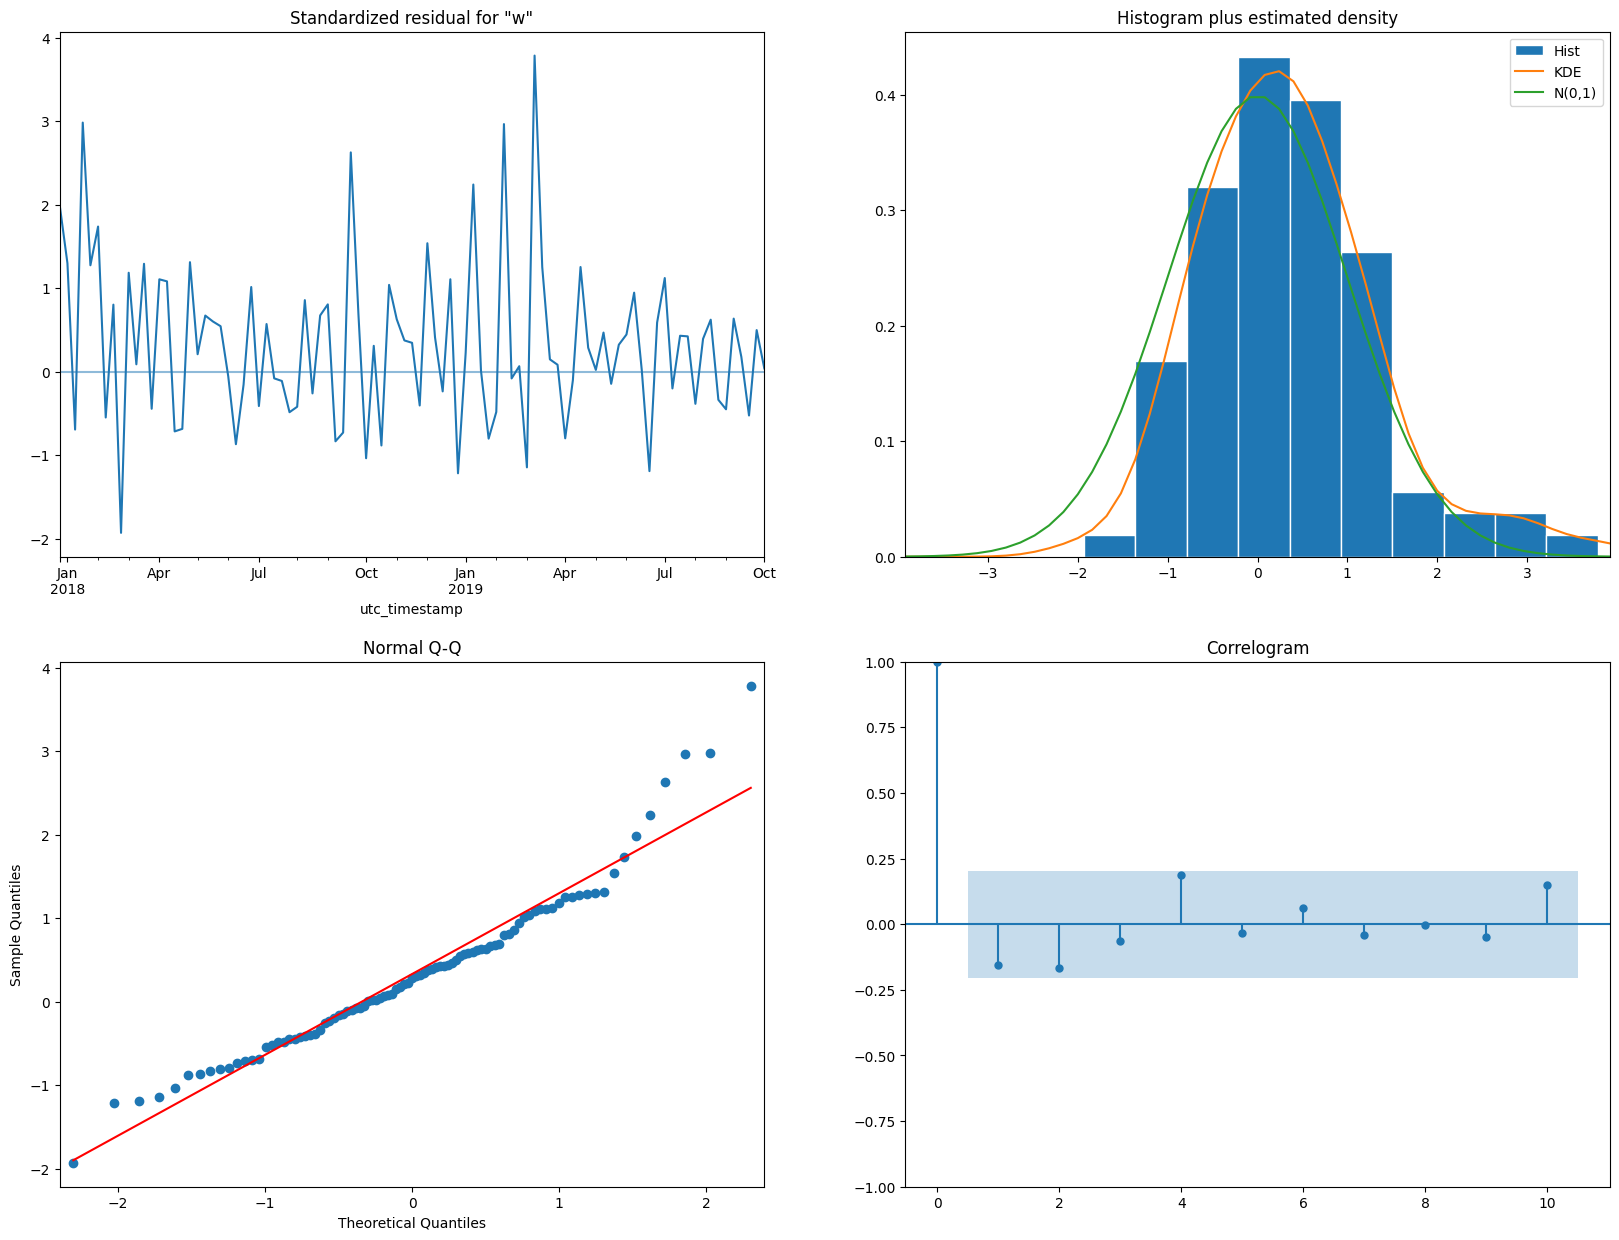

In [44]:
print(result_auto_Sarima.summary())
result_auto_Sarima.plot_diagnostics(figsize=(20,15));

The residual plot shows that there is a lot of flatuation between the residuals and the fitted values. So we expect that the forecasting is not going to produce a good forecast.

In [45]:
print('Durbin Watson: ', durbin_watson(result_auto_Sarima.resid))

Durbin Watson:  1.050982413779918


The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals.

The value lies between 0 and 4. For r == 0, the test statistic equals 2, so there is NO correlation between the residuals. If the value is closer to 0, there is a positive serial correlation; if the value is closer to 4, there is a negative serial correlation.
In this case, the value is 1.05 so there is a positive correlation between the residuals. So this means that we did NOT use the most information.

In [46]:
ljung_test = acorr_ljungbox(result_auto_Sarima.resid, period=52)
ljung_test.head()

,lb_stat,lb_pvalue
1,6.842877,8.899541e-03
2,12.472265,1.957411e-03
3,24.385346,2.075480e-05
4,46.214912,2.221829e-09
5,51.519691,6.767919e-10


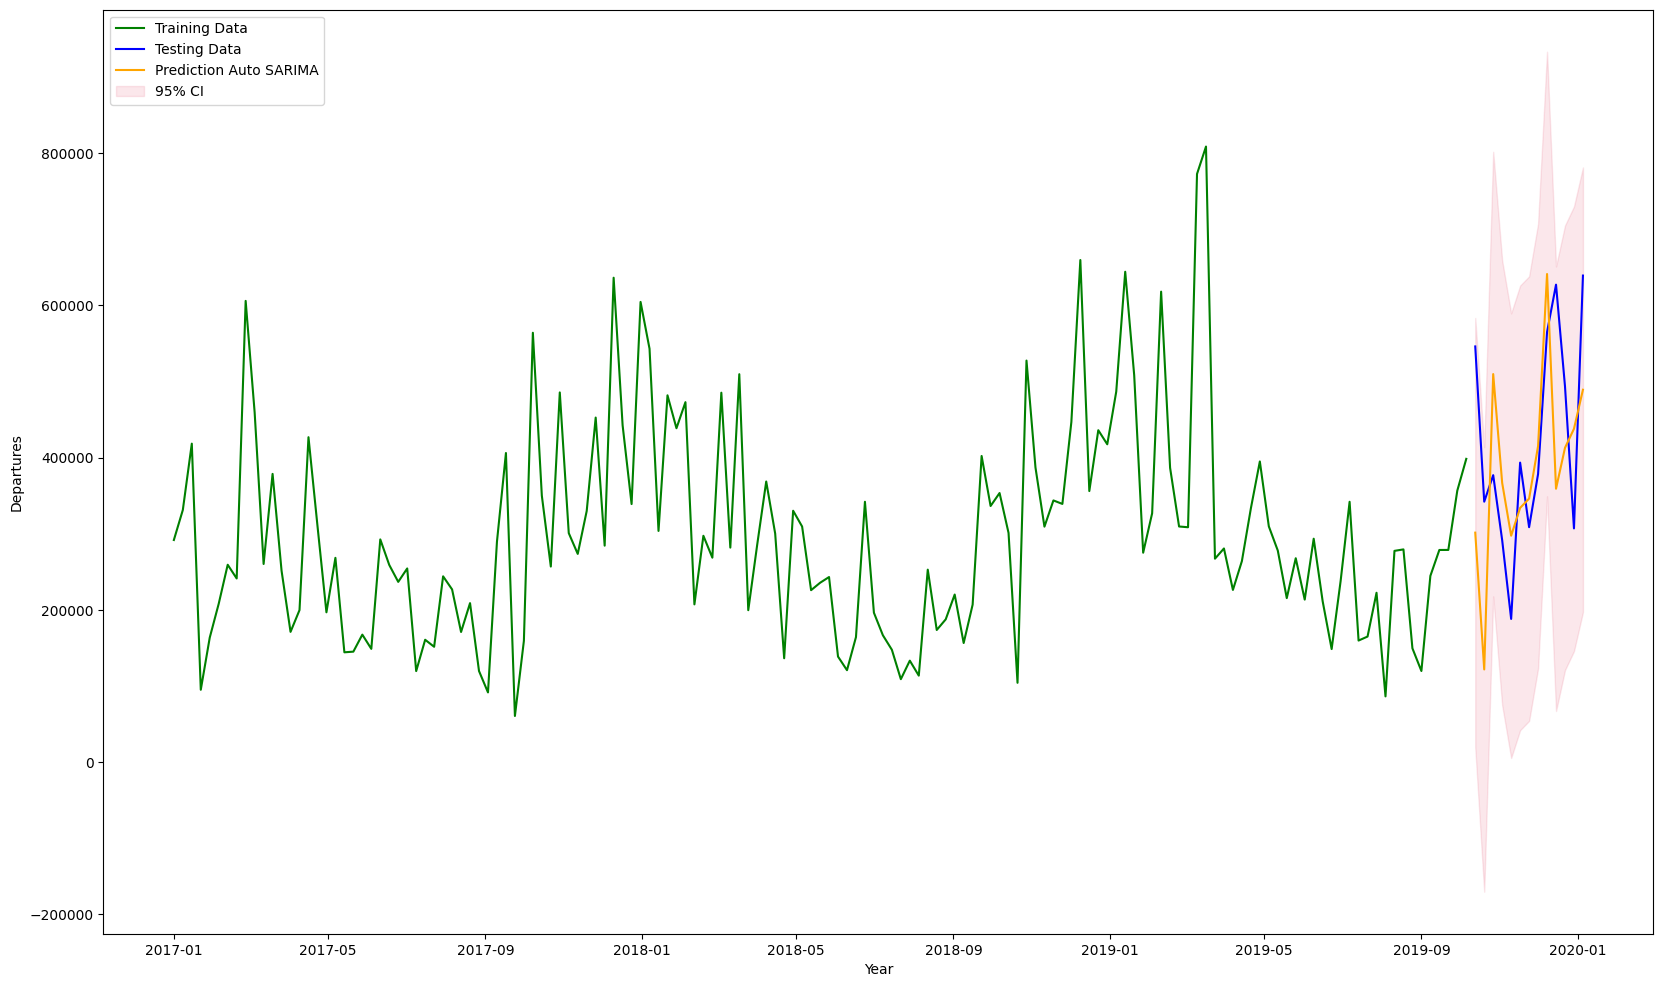

In [47]:
model_auto_SARIMA = result_auto_Sarima.get_prediction(start=data_test.index[0], end=data_test.index[-1])
auto_Sarima_df = model_auto_SARIMA.summary_frame()
plt.figure(figsize=(20,12))
plt.plot(data_train, color='green', label='Training Data')
plt.plot(data_test, color='blue', label='Testing Data')
plt.plot(auto_Sarima_df['mean'], color='orange', label='Prediction Auto SARIMA')
plt.fill_between(auto_Sarima_df.index, auto_Sarima_df['mean_ci_lower'], auto_Sarima_df['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Departures')
plt.legend()
plt.show()

In [48]:
auto_Sarima = pd.Series({'Model_name':'Auto Sarima', 'AIC':result_auto_Sarima.aic, 'RMSE':mean_squared_error(data_test, auto_Sarima_df['mean'], squared=False), 
                         'MAE':mean_absolute_error(data_test, auto_Sarima_df['mean']), 'MAPE':mean_absolute_percentage_error(data_test, auto_Sarima_df['mean'])})
metrics_df = pd.concat([metrics_df, auto_Sarima.to_frame().T])

**3. SARIMAX**

I've other two features in the dataset that we can exploit to get a better forecasting: temperature and wind_capacity. Before with the correlation matrix, i can see that there was a negative correlation between these two features. So now, we can see if using this features, there is an increases in our model predictions.

**Prepare the data** --> Calculate the *Exogenus variables*

In [49]:
#For Wind Capability:
weekly_wind_capacity = wind_energy['wind_capacity']
weekly_wind_capacity = weekly_wind_capacity.resample("W").mean()
weekly_wind_capacity_train = weekly_wind_capacity[:-13]
weekly_wind_capacity_test = weekly_wind_capacity[-13:]

#For Temperature
weekly_temperature = wind_energy['temperature']
weekly_temperature = weekly_temperature.resample("W").mean()
weekly_temperature_train = weekly_temperature[:-13]
weekly_temperature_test = weekly_temperature[-13:]


**Temperature as Exogeneous Variable**

In [50]:
#Sarima train test
train_exog = pd.concat([weekly_temperature_train], axis=1)
train_exog.index = weekly_wind_capacity[:-13].index

In [65]:
from pmdarima import auto_arima
arima_model = auto_arima(data_train, train_exog, start_p=0, start_q=0, d=0,
                         max_p=3, max_q=3, m=52,
                         start_P=0, start_Q=0, max_P=3, max_Q=3, D=1, seasonal=True,
                         trace=True, information_criterion='aic',
                         error_action='ignore',
                         suppress_warnings=True,
                         n_jobs=6, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2484.347, Time=0.44 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2475.961, Time=3.92 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2475.592, Time=7.16 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2815.699, Time=0.59 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2486.063, Time=0.53 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=13.41 sec
 ARIMA(0,0,1)(0,1,2)[52] intercept   : AIC=2476.977, Time=23.77 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=2476.695, Time=4.00 sec
 ARIMA(0,0,1)(1,1,2)[52] intercept   : AIC=inf, Time=33.88 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2477.247, Time=3.12 sec
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=2471.044, Time=6.72 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=2487.471, Time=1.75 sec
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=2472.150, Time=10.69 sec
 ARIMA(1,0,1)(0,1,2)[52] intercept   : AIC=2472.681, Time=24.22 sec
 ARIMA(1,0,1)(1,1,0)[52]

In [51]:
(p, d, q) = (1, 0, 1)
(P, D, Q) = (0, 1, 1)
S = 52

In [52]:
model_SARIMA = SARIMAX(data_train, exog=train_exog,
                       order=(p,d,q),
                       seasonal_order=(P,D,Q,S),
                       enforce_invertibility=False)
#Fit model
result_Sarima_exog = model_SARIMA.fit(disp=False)

                                     SARIMAX Results                                      
Dep. Variable:             wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1237.722
Date:                            Thu, 13 Feb 2025   AIC                           2485.444
Time:                                    11:25:33   BIC                           2498.107
Sample:                                01-01-2017   HQIC                          2490.557
                                     - 10-06-2019                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature  4910.6016   3564.950      1.377      0.168   -2076.572    1.19e+04
ar.L1          -0.0115      0.41

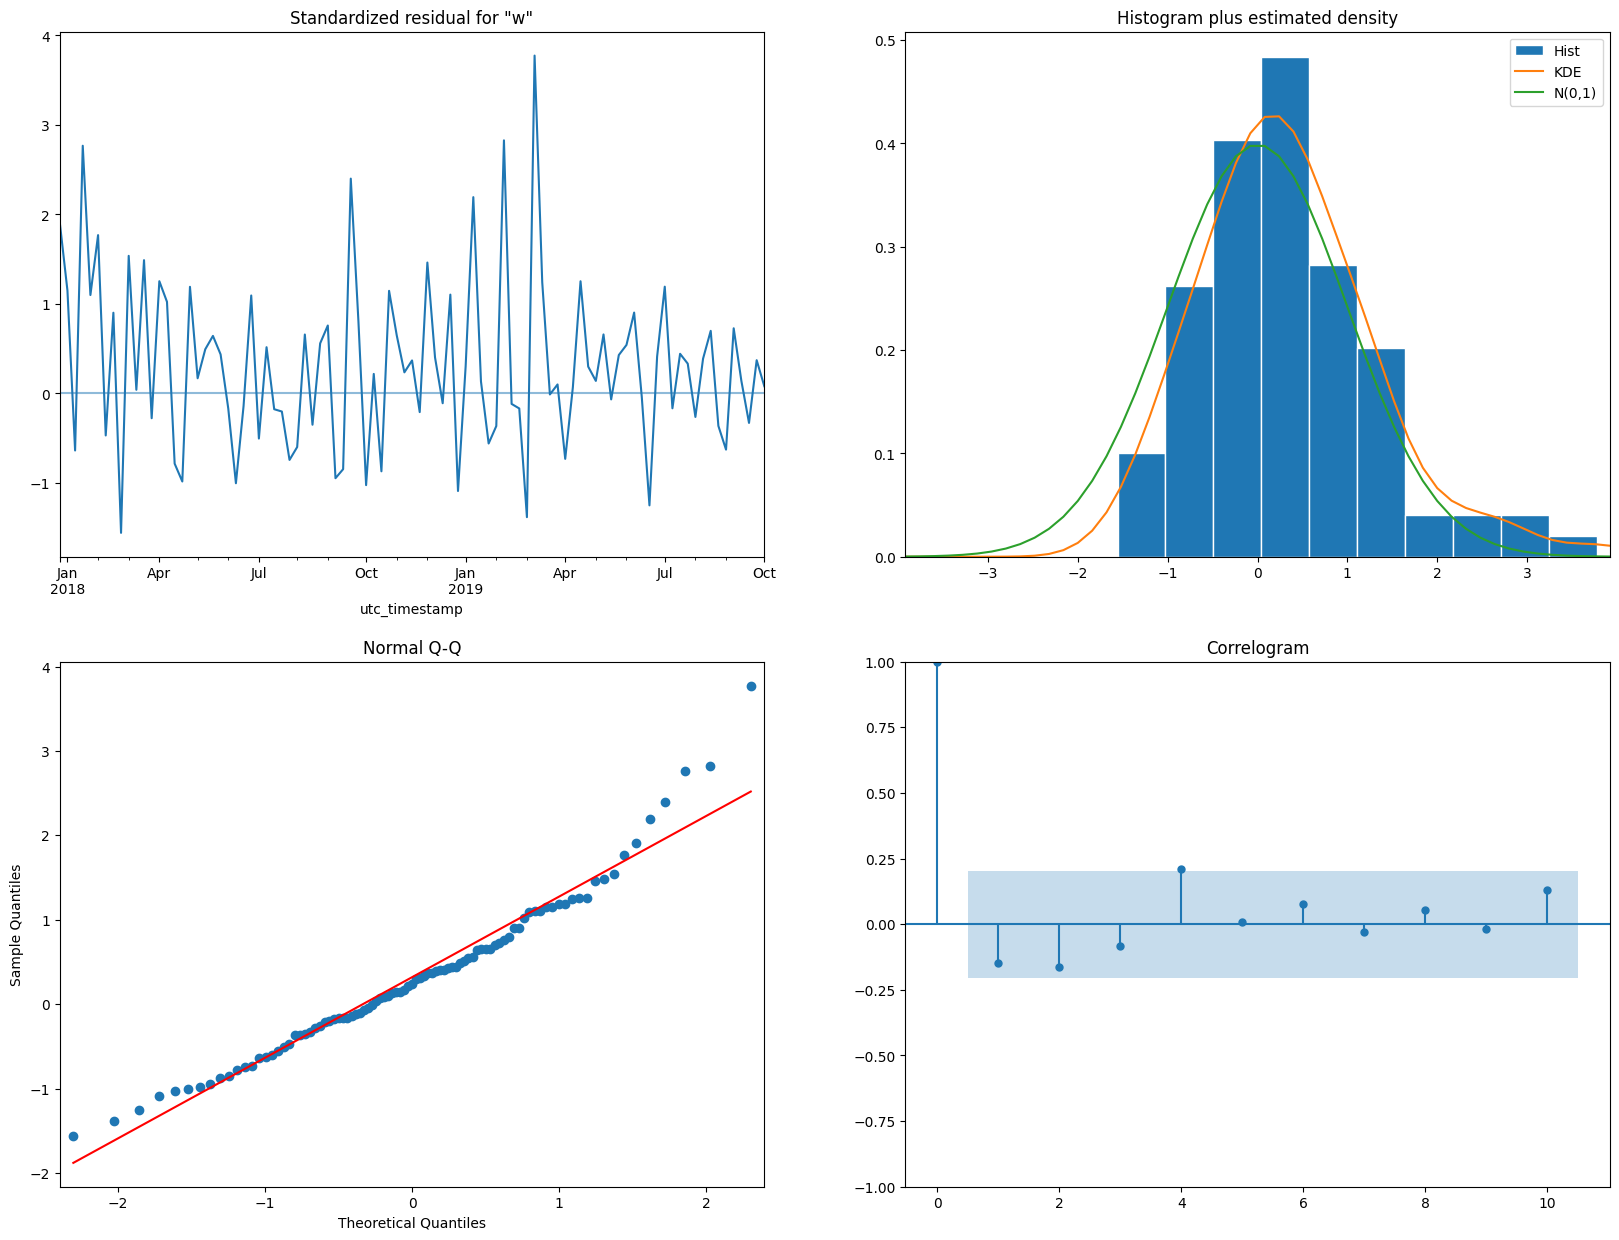

In [53]:
print(result_Sarima_exog.summary())
result_Sarima_exog.plot_diagnostics(figsize=(20,15));

**Residual Test**

In [54]:
print('Durbin Watson: ', durbin_watson(result_Sarima_exog.resid))

Durbin Watson:  1.1752210203960085


The value is 1.17 so there is a positive correlation between the residuals. So this means that we did NOT use the most information.

In [55]:
ljung_test = acorr_ljungbox(result_Sarima_exog.resid, period=52)
ljung_test.head()

,lb_stat,lb_pvalue
1,4.504421,3.380733e-02
2,7.541151,2.303881e-02
3,15.261332,1.606409e-03
4,33.204983,1.084435e-06
5,36.635435,7.086685e-07


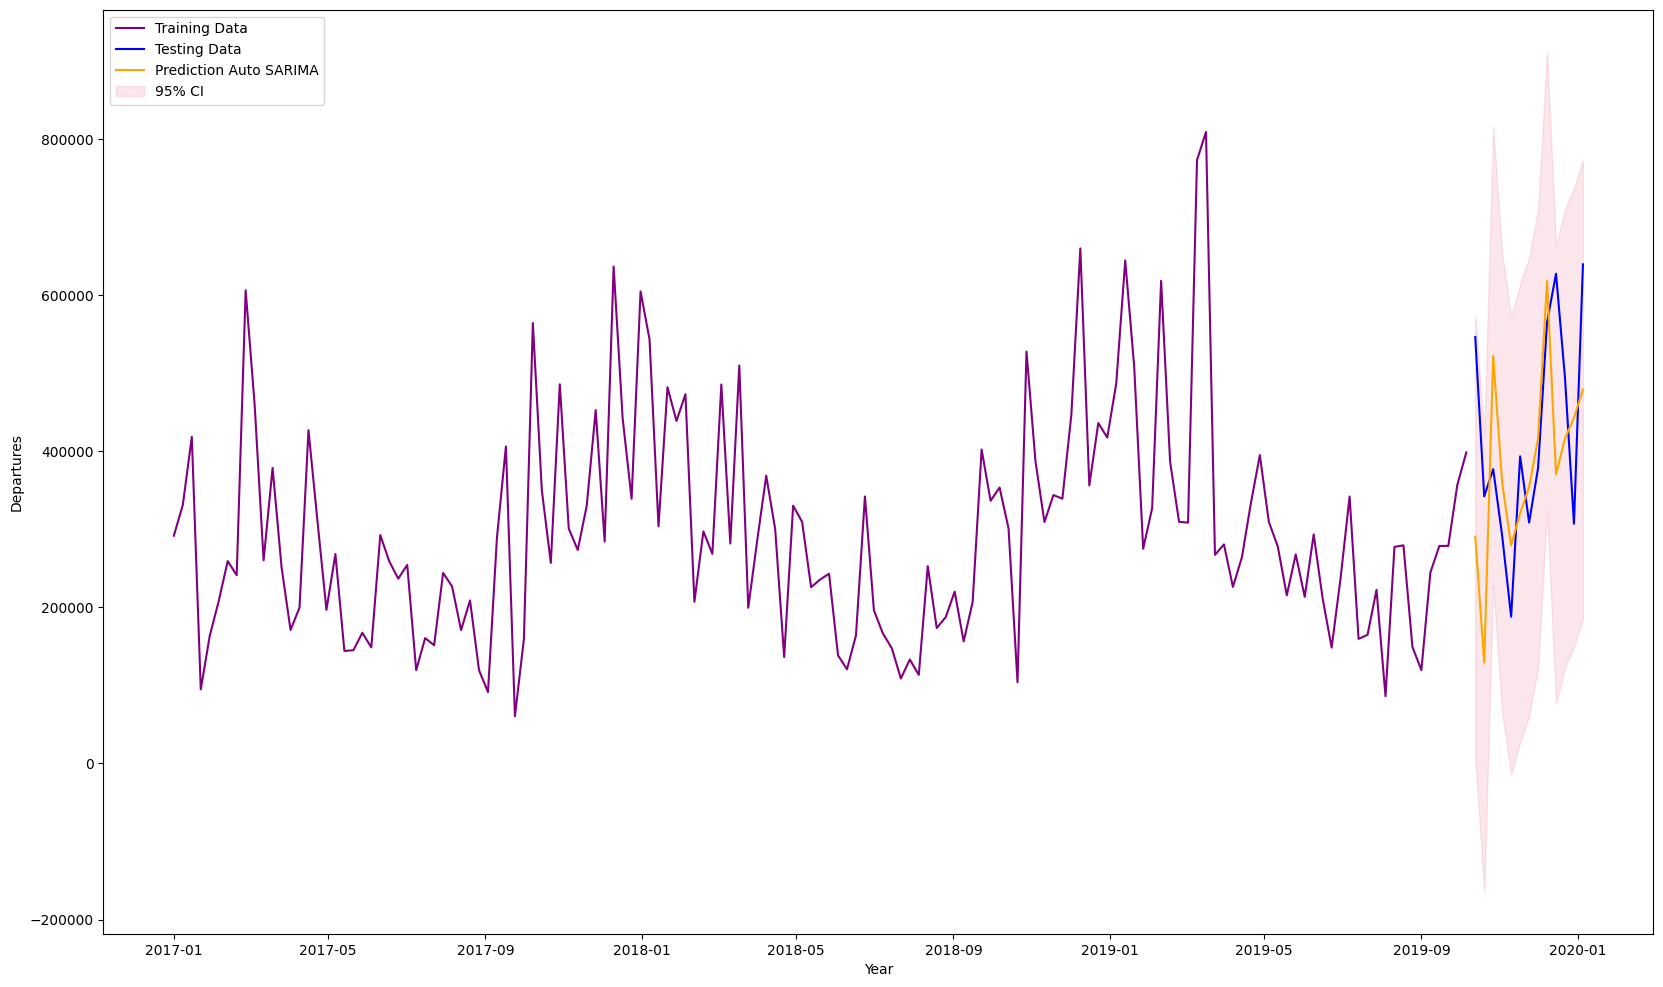

In [56]:
#Forecasting with Manual Sarimax model
train_exog = pd.concat([weekly_temperature_test], axis=1)
train_exog.index = weekly_wind_capacity_test.index
model_SARIMA_exog = result_Sarima_exog.get_prediction(start=data_test.index[0], end=data_test.index[-1], exog=train_exog)
Sarima_exog_df = model_SARIMA_exog.summary_frame()
plt.figure(figsize=(20,12))
plt.plot(data_train, color='purple', label='Training Data')
plt.plot(data_test, color='blue', label='Testing Data')
plt.plot(Sarima_exog_df['mean'], color='orange', label='Prediction Auto SARIMA')
plt.fill_between(Sarima_exog_df.index, Sarima_exog_df['mean_ci_lower'], Sarima_exog_df['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Departures')
plt.legend()
plt.show()

In [57]:
Sarimax = pd.Series({'Model_name':'Sarimax Temperature', 'AIC':result_Sarima_exog.aic, 'RMSE':mean_squared_error(data_test, Sarima_exog_df['mean'], squared=False), 
                         'MAE':mean_absolute_error(data_test, Sarima_exog_df['mean']), 'MAPE':mean_absolute_percentage_error(data_test, Sarima_exog_df['mean'])})
metrics_df = pd.concat([metrics_df, Sarimax.to_frame().T])

**Wind Capacity as Exogeneous Variable**

In [58]:
#Prepare the data
train_exog = pd.concat([weekly_wind_capacity_train], axis=1)
train_exog.index = weekly_wind_capacity[:-13].index

In [81]:
from pmdarima import auto_arima
arima_model = auto_arima(data_train, train_exog, start_p=0, start_q=0, d=0,
                         max_p=3, max_q=3, m=52,
                         start_P=0, start_Q=0, max_P=3, max_Q=3, D=1, seasonal=True,
                         trace=True, information_criterion='aic',
                         error_action='ignore',
                         suppress_warnings=True,
                         n_jobs=6, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2485.804, Time=0.52 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2465.163, Time=6.55 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=7.71 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2813.368, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=2487.551, Time=0.88 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=2466.365, Time=21.71 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=2466.420, Time=9.13 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=2466.360, Time=6.84 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=2468.365, Time=52.56 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2466.408, Time=6.91 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=2463.644, Time=11.72 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=2485.005, Time=2.22 sec
 ARIMA(2,0,0)(2,1,0)[52] intercept   : AIC=2465.222, Time=46.18 sec
 ARIMA(2,0,0)(1,1,1)[52] intercept   : AIC=2465.253, Time=19.50 sec
 ARIMA(2,0,0)(0,1,1

In [59]:
(p, d, q) = (0, 0, 1)
(P, D, Q) = (1, 1, 0)
S = 52

In [60]:
model_SARIMA = SARIMAX(data_train, exog=train_exog,
                       order=(p,d,q),
                       seasonal_order=(P,D,Q,S),
                       enforce_invertibility=False)
#Fit model
result_Sarima_exog_wind_capacity = model_SARIMA.fit(disp=False)

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood               -1226.214
Date:                             Thu, 13 Feb 2025   AIC                           2460.428
Time:                                     11:25:58   BIC                           2470.558
Sample:                                 01-01-2017   HQIC                          2464.518
                                      - 10-06-2019                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
wind_capacity     6.4478      1.015      6.353      0.000       4.459       8.437
ma.L1             

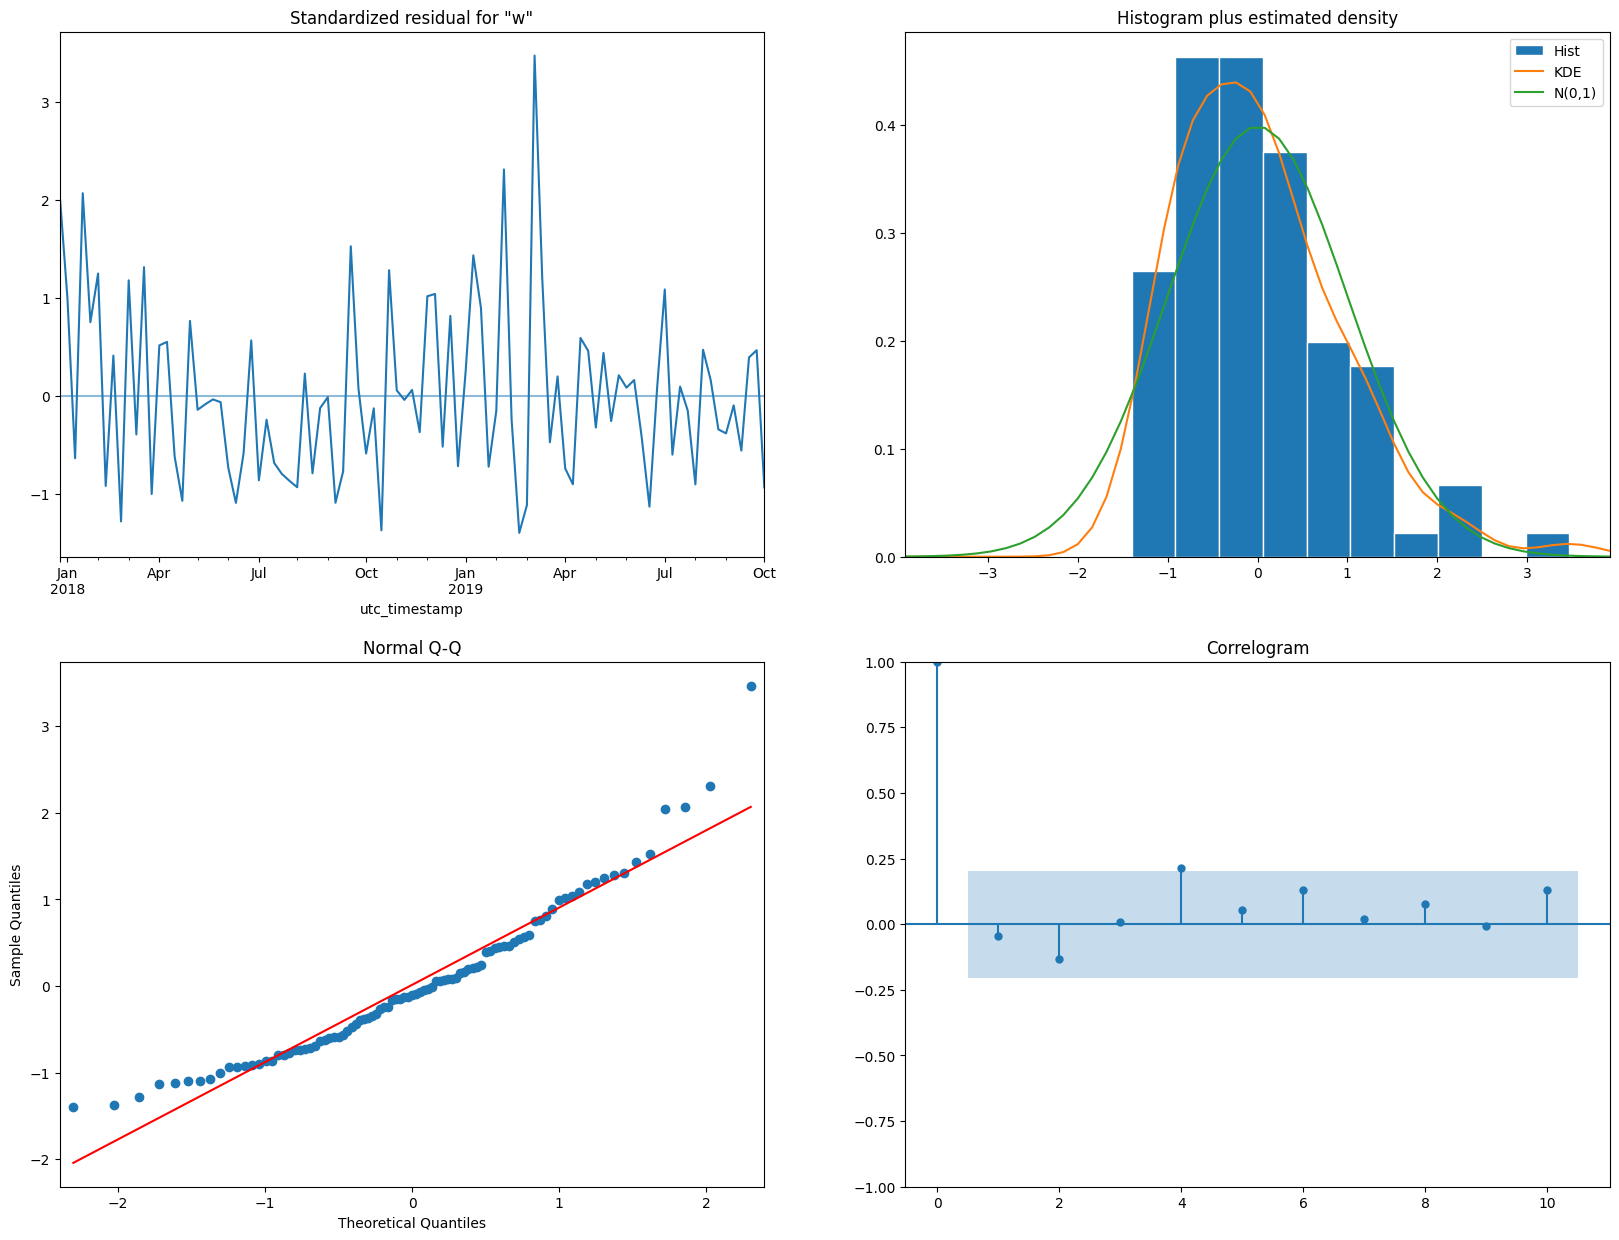

In [61]:
print(result_Sarima_exog_wind_capacity.summary())
result_Sarima_exog_wind_capacity.plot_diagnostics(figsize=(20,15));

**Residual test**

In [62]:
print('Durbin Watson: ', durbin_watson(result_Sarima_exog_wind_capacity.resid))

Durbin Watson:  2.0093330154506868


In [63]:
ljung_test = acorr_ljungbox(result_Sarima_exog_wind_capacity.resid, period=52)
ljung_test.head()

,lb_stat,lb_pvalue
1,0.022649,0.880374
2,1.081962,0.582177
3,4.138807,0.246860
4,9.648872,0.046777
5,9.778769,0.081752


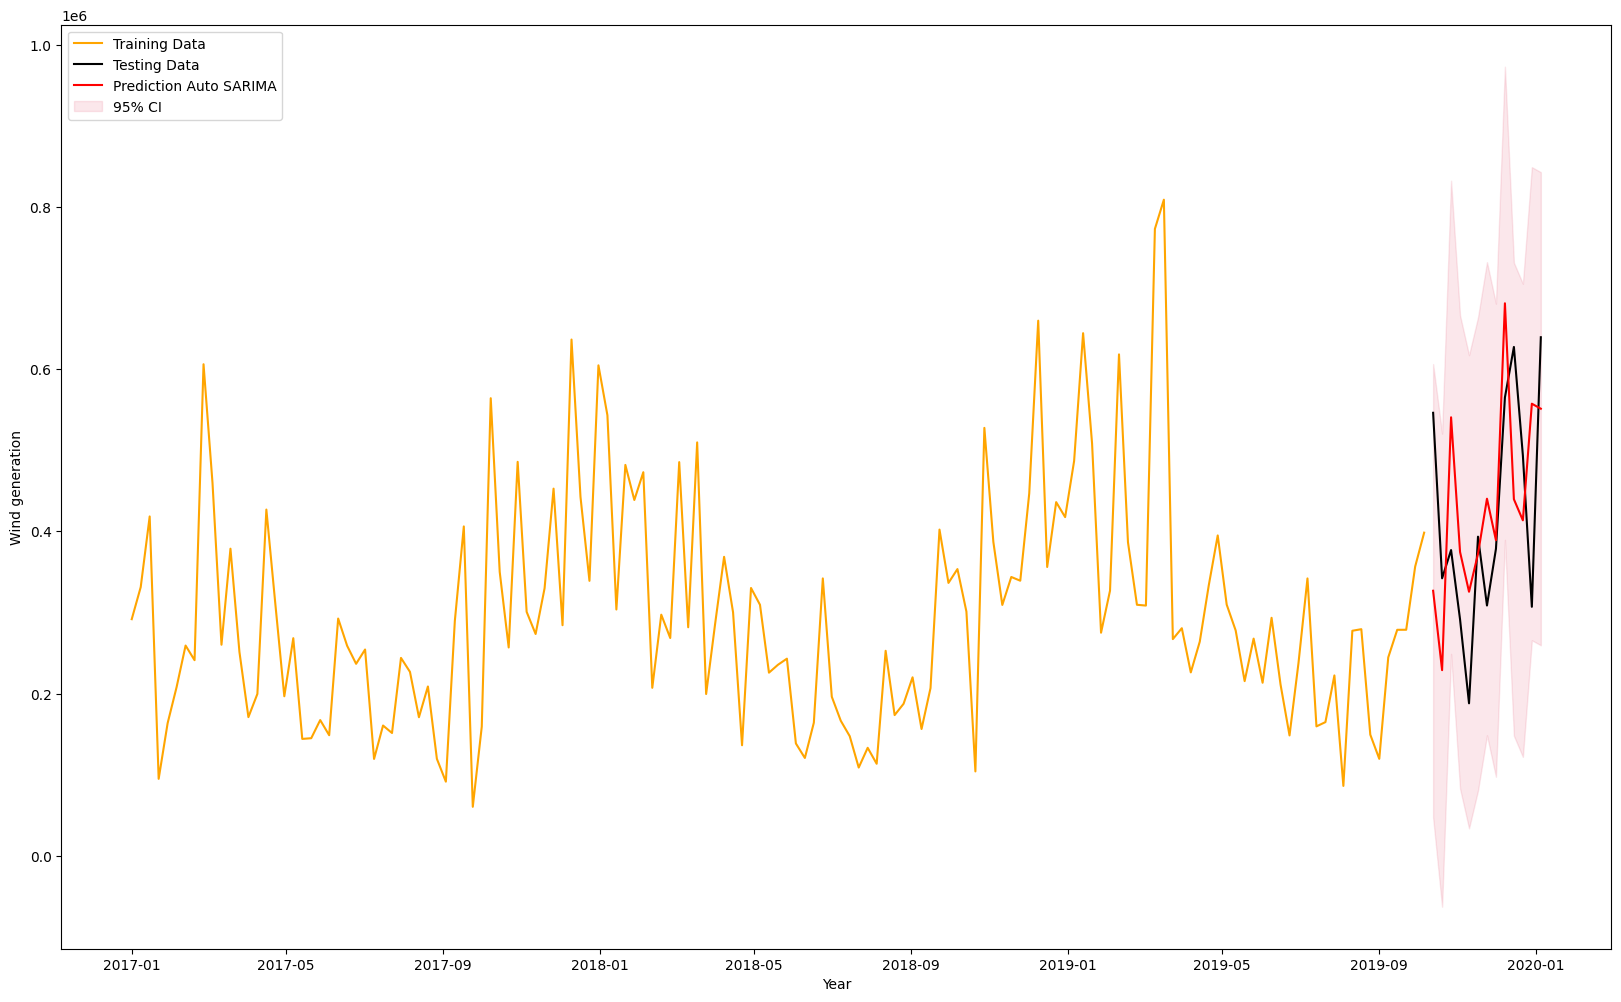

In [68]:
#Forecasting with Manual Sarimax model
train_exog = pd.concat([weekly_wind_capacity_test], axis=1)
train_exog.index = weekly_wind_capacity_test.index
model_SARIMA_exog_wind_capacity = result_Sarima_exog_wind_capacity.get_prediction(start=data_test.index[0], end=data_test.index[-1], exog=train_exog)
Sarima_exog_wind_df = model_SARIMA_exog_wind_capacity.summary_frame()
plt.figure(figsize=(20,12))
plt.plot(data_train, color='orange', label='Training Data')
plt.plot(data_test, color='black', label='Testing Data')
plt.plot(Sarima_exog_wind_df['mean'], color='red', label='Prediction Auto SARIMA')
plt.fill_between(Sarima_exog_wind_df.index, Sarima_exog_wind_df['mean_ci_lower'], Sarima_exog_wind_df['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Wind generation')
plt.legend()
plt.show()

In [69]:
Sarimax_wind = pd.Series({'Model_name':'Sarimax Wind Capacity', 'AIC':result_Sarima_exog_wind_capacity.aic, 'RMSE':mean_squared_error(data_test, Sarima_exog_wind_df['mean'], squared=False), 
                         'MAE':mean_absolute_error(data_test, Sarima_exog_wind_df['mean']), 'MAPE':mean_absolute_percentage_error(data_test, Sarima_exog_wind_df['mean'])})
metrics_df = pd.concat([metrics_df, Sarimax_wind.to_frame().T])

**Wind Capacity and Temperature**

In [70]:
#Prepare the data
train_exog = pd.concat([weekly_temperature_train , weekly_wind_capacity_train], axis=1)
train_exog.index = weekly_wind_capacity[:-13].index

In [ ]:
from pmdarima import auto_arima
arima_model = auto_arima(data_train, train_exog, start_p=0, start_q=0, d=0,
                         max_p=3, max_q=3, m=52,
                         start_P=0, start_Q=0, max_P=3, max_Q=3, D=1, seasonal=True,
                         trace=True, information_criterion='aic',
                         error_action='ignore',
                         suppress_warnings=True,
                         n_jobs=6, 
                         stepwise=True)

In [71]:
(p, d, q) = (0, 0, 1)
(P, D, Q) = (1, 1, 0)
S = 52

In [72]:
model_SARIMA = SARIMAX(data_train, exog=train_exog,
                       order=(p,d,q),
                       seasonal_order=(P,D,Q,S),
                       enforce_invertibility=False)
#Fit model
result_Sarima_exog_all_features = model_SARIMA.fit(disp=False)

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood               -1228.043
Date:                             Thu, 13 Feb 2025   AIC                           2466.087
Time:                                     11:34:38   BIC                           2478.750
Sample:                                 01-01-2017   HQIC                          2471.200
                                      - 10-06-2019                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temperature    3802.9001   4401.625      0.864      0.388   -4824.127    1.24e+04
wind_capacity     

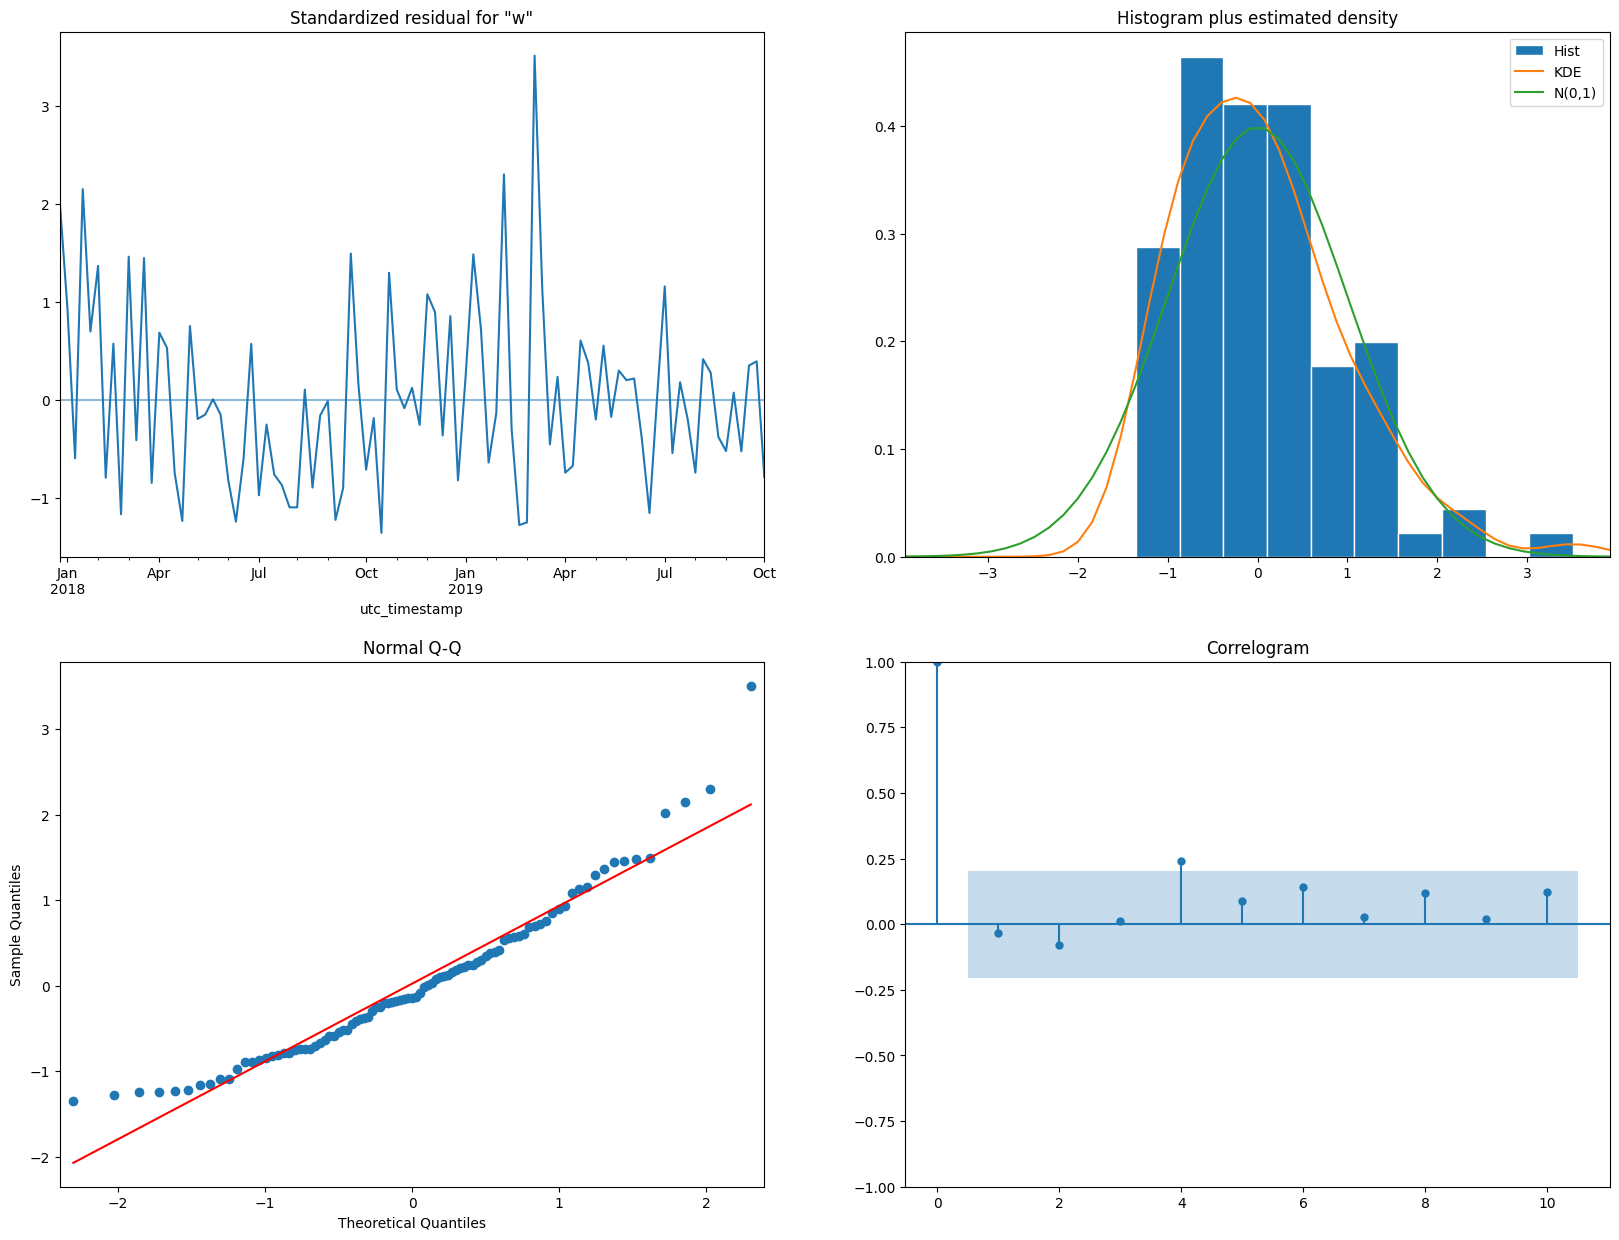

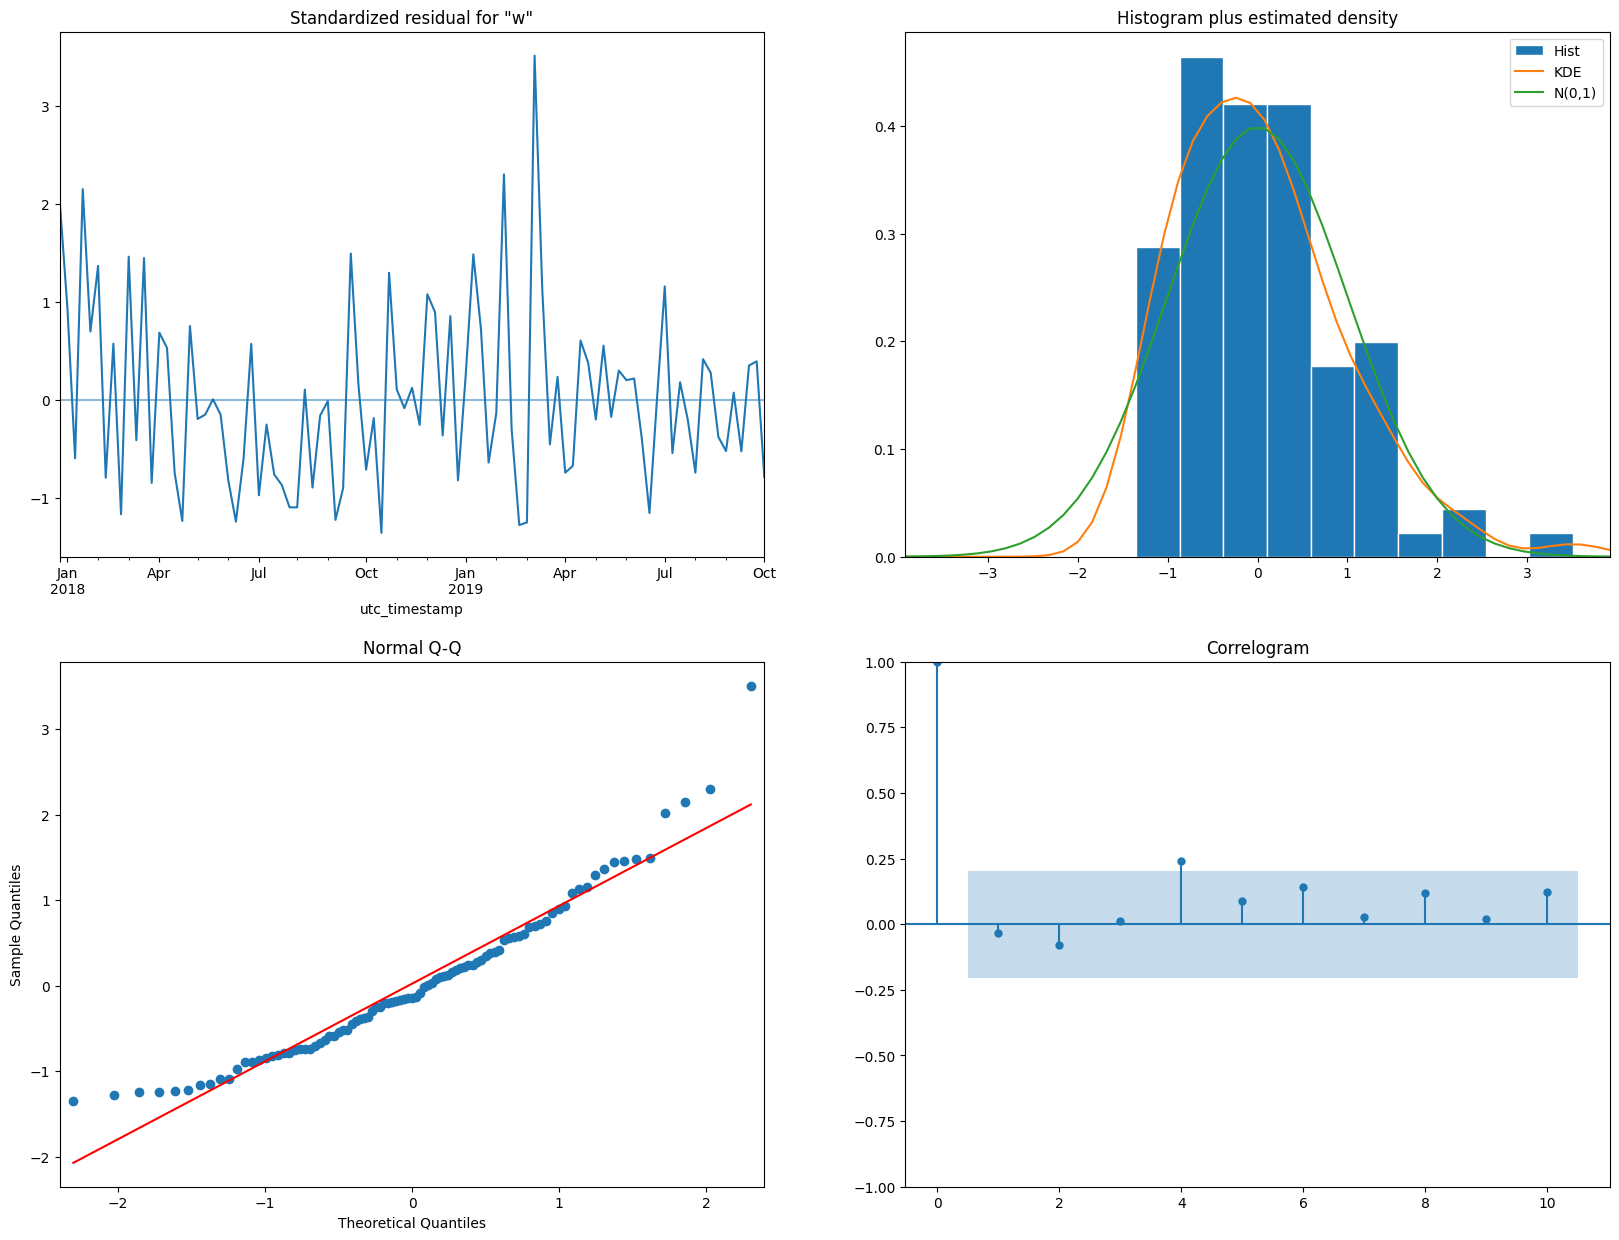

In [73]:
print(result_Sarima_exog_all_features.summary())
result_Sarima_exog_all_features.plot_diagnostics(figsize=(20,15))

**Residuals test**

In [76]:
print("Durbin Watson:", durbin_watson(result_Sarima_exog_all_features.resid))

Durbin Watson: 1.907651906527406


In [78]:
ljung_test = acorr_ljungbox(result_Sarima_exog_all_features.resid, period=52)
ljung_test.head()

,lb_stat,lb_pvalue
1,0.221689,0.637756
2,0.225833,0.893225
3,4.549119,0.207951
4,13.169829,0.010475
5,13.342905,0.020369


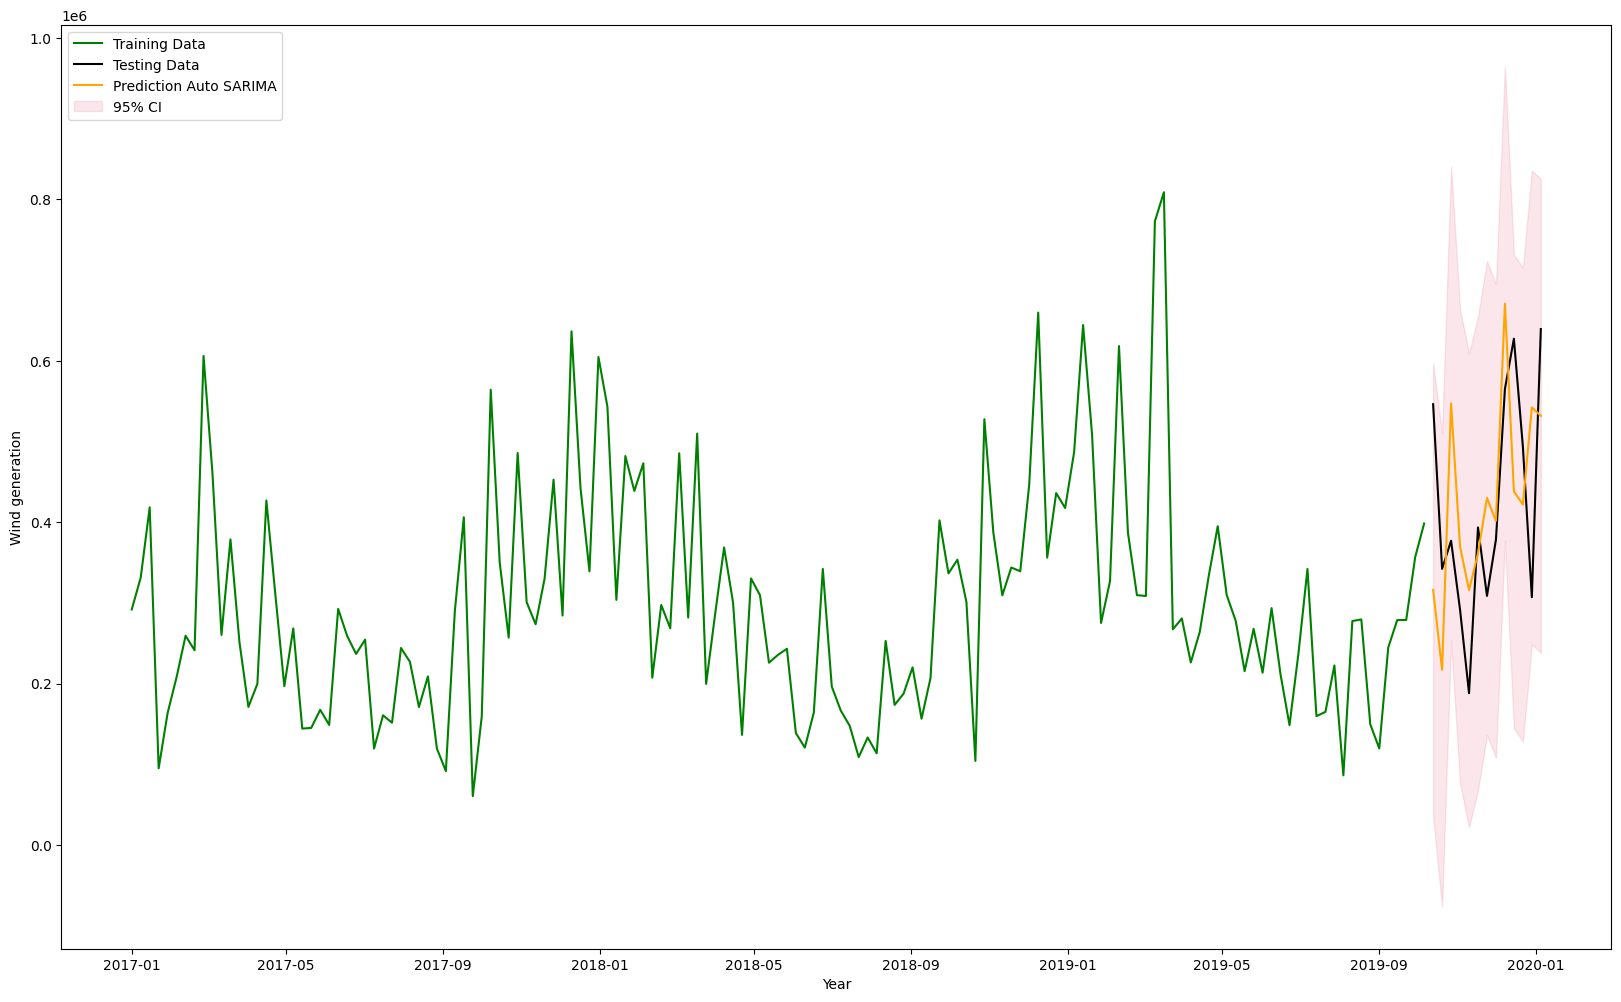

In [79]:
#Forecasting with Manual Sarimax model
train_exog = pd.concat([weekly_temperature_test, weekly_wind_capacity_test], axis=1)
train_exog.index = weekly_wind_capacity_test.index
model_SARIMA_exog_all_features = result_Sarima_exog_all_features.get_prediction(start=data_test.index[0], end=data_test.index[-1], exog=train_exog)
Sarima_exog_all_features_df = model_SARIMA_exog_all_features.summary_frame()
plt.figure(figsize=(20,12))
plt.plot(data_train, color='green', label='Training Data')
plt.plot(data_test, color='black', label='Testing Data')
plt.plot(Sarima_exog_all_features_df['mean'], color='orange', label='Prediction Auto SARIMA')
plt.fill_between(Sarima_exog_all_features_df.index, Sarima_exog_all_features_df['mean_ci_lower'], Sarima_exog_all_features_df['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Wind generation')
plt.legend()
plt.show()

In [80]:
Sarimax_all_features = pd.Series({'Model_name':'Sarimax All Features', 'AIC':result_Sarima_exog_all_features.aic, 'RMSE':mean_squared_error(data_test, Sarima_exog_all_features_df['mean'], squared=False), 
                         'MAE':mean_absolute_error(data_test, Sarima_exog_all_features_df['mean']), 'MAPE':mean_absolute_percentage_error(data_test, Sarima_exog_all_features_df['mean'])})
metrics_df = pd.concat([metrics_df, Sarimax_all_features.to_frame().T])

**ETS**